#### Imports

In [66]:
using Plots
using Random

# Motion Planning Using Convex Optimization

## Model

In [67]:
struct Point
    x::Float64
    y::Float64
end

In [68]:
struct Pose
    position::Point
    orientation::Float64
end

## General Functions

In [69]:
function angleCalculator(dif_x, dif_y)
    ang_aux = 180*atan(dif_y,dif_x)/pi
    println("Raw angle = ", ang_aux)
    if (dif_x >=0 && dif_y >= 0) #top right
        ang_aux = 180 - ang_aux
    elseif (dif_x >=0 && dif_y < 0) #bot right
        ang_aux = abs(ang_aux) + 180
    elseif (dif_x < 0 && dif_y >= 0) #top left
        ang_aux = 180 - ang_aux
    elseif (dif_x < 0 && dif_y < 0) #bot left
        ang_aux = abs(ang_aux) + 180
    end
    println("Corrected angle = ", ang_aux, "\n\n")

    return ang_aux
end

angleCalculator (generic function with 1 method)

## Random Map Generation

### Random Convex Polygon Generation

In [70]:
function GenerateRandomConvexPolygon(numberOfVertices::Int64)
    # Still remains a test for convexity and 
    #keep up with the computation until a convex poligon is found
    
    xCoordinateRandomPoints = []
    yCoordinateRandomPoints = []

    #Generate two lists of random X and Y coordinates
    
    for i in 1:numberOfVertices
        append!(xCoordinateRandomPoints, rand())
        append!(yCoordinateRandomPoints, rand(0:0.001:1))
        println("X gerado: ", xCoordinateRandomPoints[i],", Y gerado: ", yCoordinateRandomPoints[i],)
    end

    println("\n\n")

    #Sort them

    sort!(xCoordinateRandomPoints)
    sort!(yCoordinateRandomPoints)
    println("ordenando...")

    for i in 1:numberOfVertices
        println("X: ", xCoordinateRandomPoints[i],", Y: ", yCoordinateRandomPoints[i],)
    end

    #Isolate the extreme points
    minimumX = xCoordinateRandomPoints[1]
    maximumX = xCoordinateRandomPoints[numberOfVertices]
    minimumY = yCoordinateRandomPoints[1]
    maximumY = yCoordinateRandomPoints[numberOfVertices]


    xVectors = []
    yVectors = []

    lastTop = minimumX
    lastBot = minimumX;

    println("separando em duas correntes...")
    for i in 2:numberOfVertices-1
        x = xCoordinateRandomPoints[i];

        if rand(Bool) #Randomly divide the interior points into two chains
            append!(xVectors, x - lastTop) #Extract the vector components
            lastTop = x;
        else 
            append!(xVectors, lastBot - x)
            lastBot = x;
        end
        println("xVectors[", i-1, "] = ", xVectors[i-1])
    end

    append!(xVectors, maximumX - lastTop)
    append!(xVectors, lastBot - maximumX)

    lastLeft = minimumY
    lastRight = minimumY;

    for i in 2:numberOfVertices-1
        y = yCoordinateRandomPoints[i];

        if rand(Bool)
            append!(yVectors, y - lastLeft)
            lastLeft = y;
        else 
            append!(yVectors, lastRight - y)
            lastRight = y;
        end
    end

    append!(yVectors, maximumY - lastLeft)
    append!(yVectors, lastRight - maximumY)

    #Randomly pair up the X- and Y-components
    #Combine the paired up components into vectors
    shuffle(yVectors);

    points = []
    angles = []
    ang_aux = 0
    for i in 1:numberOfVertices
        push!(points, Point(xVectors[i],yVectors[i]))
        println("Ponto ", i, ": x = ", points[i].x, ", e y = ", points[i].y)
        ang_aux = 180*atan(yVectors[i],xVectors[i])/pi
        println("Ângulo cru = ", ang_aux)
        if (xVectors[i] >=0 && yVectors[i] >= 0) #top right
            ang_aux = 180 - ang_aux
        elseif (xVectors[i] >=0 && yVectors[i] < 0) #bot right
            ang_aux = abs(ang_aux) + 180
        elseif (xVectors[i] < 0 && yVectors[i] >= 0) #top left
            ang_aux = 180 - ang_aux
        elseif (xVectors[i] < 0 && yVectors[i] < 0) #bot left
            ang_aux = abs(ang_aux) + 180
        end
        append!(angles, ang_aux)
        println("Com ângulo = ", angles[i], "\n\n")
    end

    #Sort the vectors by angle
    order = sortperm(angles)
    points = points[order]

    for p in points
        println(p.x,", ",p.y)
    end

    x = 0.0
    y = 0.0
    minPolygonX = 0;
    minPolygonY = 0;
    newPoints = []
    println("gerando pontos:")
    for i in 1:numberOfVertices 
        push!(newPoints, Point(x,y))
        println("x = ", newPoints[i].x, ", y = ", newPoints[i].y)
        x += points[i].x;
        y += points[i].y;
        minPolygonX = min(minPolygonX, x)
        minPolygonY = min(minPolygonY, y)
    end
    
    println("\nshift:")
    xShift = maxPrevX + rand(0.5:0.001:2) - minPolygonX;
    yShift = minimumY - minPolygonY;
    println("XShift = ", xShift, ", YShift", yShift)

    println("pontos deslocados:")
    for i in 1:numberOfVertices 
        p = newPoints[i]
        points[i] = Point(p.x + xShift, p.y + yShift)
        println("x = ", points[i].x, ", y = ", points[i].y)
    end
    
    return points;
end

GenerateRandomConvexPolygon (generic function with 1 method)

In [71]:
n_obstacle = rand(1:10)
obstacle = []
n_vertice = []
all_vertices = 0
maxPrevX = rand(-10:0.1:0)
for i in 1:n_obstacle
    push!(n_vertice, rand(10:50))
    all_vertices += n_vertice[i]
    push!(obstacle, GenerateRandomConvexPolygon(n_vertice[i]))
    maxPrevX = -100
    for j in 1:n_vertice[i]
        maxPrevX = max(obstacle[i][j].x, maxPrevX)
    end
end

 #obstacle points
xs = []
ys = []
for i in 1:n_obstacle
    x_ob = []
    y_ob = []
    for j in 1:n_vertice[i]
        append!(x_ob, obstacle[i][j].x)
        append!(y_ob, obstacle[i][j].y)
    end
    append!(x_ob, obstacle[i][1].x)
    append!(y_ob, obstacle[i][1].y)
    push!(xs,x_ob)
    push!(ys,y_ob)
end



X gerado: 0.19614462282648193, Y gerado: 0.311
X gerado: 0.34700391560047805, Y gerado: 0.581
X gerado: 0.4319658714348841, Y gerado: 0.694
X gerado: 0.753259468366483, Y gerado: 0.955
X gerado: 0.6353937632063076, Y gerado: 0.28
X gerado: 0.47357113201814205, Y gerado: 0.32
X gerado: 0.981658035022219, Y gerado: 0.304
X gerado: 0.6702685000095164, Y gerado: 0.023
X gerado: 0.23426707380435574, Y gerado: 0.41
X gerado: 0.44527953724381053, Y gerado: 0.521
X gerado: 0.5807348007967339, Y gerado: 0.359
X gerado: 0.25836190608649834, Y gerado: 0.991
X gerado: 0.7618575965164536, Y gerado: 0.13
X gerado: 0.7964547986627438, Y gerado: 0.016
X gerado: 0.8225631922966248, Y gerado: 0.86
X gerado: 0.38703881074171886, Y gerado: 0.334
X gerado: 0.8370065046006868, Y gerado: 0.098
X gerado: 0.7864221238775966, Y gerado: 0.868
X gerado: 0.6543145657604329, Y gerado: 0.682
X gerado: 0.9716300173846817, Y gerado: 0.081



ordenando...
X: 0.19614462282648193, Y: 0.016
X: 0.23426707380435574

, Y: 0.023
X: 0.25836190608649834, Y: 0.081
X: 0.34700391560047805, Y: 0.098
X: 0.38703881074171886, Y: 0.13
X: 0.4319658714348841, Y: 0.28
X: 0.44527953724381053, Y: 0.304
X: 0.47357113201814205, Y: 0.311
X: 0.5807348007967339, Y: 0.32
X: 0.6353937632063076, Y: 0.334


X: 0.6543145657604329, Y: 0.359
X: 0.6702685000095164, Y: 0.41
X: 0.753259468366483, Y: 0.521
X: 0.7618575965164536, Y: 0.581
X: 0.7864221238775966, Y: 0.682
X: 0.7964547986627438, Y: 0.694
X: 0.8225631922966248, Y: 0.86
X: 0.8370065046006868, Y: 0.868
X: 0.9716300173846817, Y: 0.955
X: 0.981658035022219, Y: 0.991
separando em duas correntes...
xVectors[1] = -0.03812245097787381
xVectors[2] = -0.024094832282142598
xVectors[3] = 0.15085929277399612
xVectors[4] = 0.04003489514124081
xVectors[5] = 0.04492706069316521
xVectors[6] = -0.1869176311573122
xVectors[7] = -0.02829159477433152
xVectors[8] = -0.10716366877859185
xVectors[9] = -0.054658962409573686
xVectors[10] = 0.22234869432554882
xVectors[11] = -0.03487473680320885
xVectors[12] = -0.08299096835696662
xVectors[13] = -0.008598128149970519
xVectors[14] = 0.13210755811716368
xVectors[

15] = -0.03459720214629025
xVectors[16] = -0.026108393633880955
xVectors[17] = 0.05058438072309024
xVectors[18] = -0.1490668250880569
Ponto 1: x = -0.03812245097787381, e y = -0.006999999999999999
Ângulo cru = -169.5953169310365
Com ângulo = 349.5953169310365


Ponto 2: x = -0.024094832282142598, e y = 0.065
Ângulo cru = 110.33922575192034
Com ângulo = 69.66077424807966


Ponto 3: x = 0.15085929277399612, e y = 0.017
Ângulo cru = 6.429411495079202
Com ângulo = 173.5705885049208


Ponto 4: x = 0.04003489514124081, e y = 0.032
Ângulo cru = 38.6354389707234
Com ângulo = 141.36456102927662


Ponto 5: x = 0.04492706069316521, e y = -0.257
Ângulo cru = -80.08412486539466
Com ângulo = 260.08412486539464


Ponto 6: x = -0.1869176311573122, e y = -0.023999999999999966
Ângulo cru = -172.68332345826968
Com ângulo = 352.6833234582697


Ponto 7: x = -0.02829159477433152, e y = -0.007000000000000006
Ângulo cru = -166.1027897394513
Com ângulo = 346.1027897394513


Ponto 8: x = -0.10716366877859185

, e y = -0.009000000000000008
Ângulo cru = -175.19935477739057
Com ângulo = 355.19935477739057


Ponto 9: x = -0.054658962409573686, e y = -0.014000000000000012
Ângulo cru = -165.63347664118334
Com ângulo = 345.63347664118334


Ponto 10: x = 0.22234869432554882, e y = 0.22899999999999998
Ângulo cru = 45.844278858477736
Com ângulo = 134.15572114152226


Ponto 11: x = -0.03487473680320885, e y = 0.05099999999999999
Ângulo cru = 124.36503758584357
Com ângulo = 55.63496241415643


Ponto 12: x = -0.08299096835696662, e y = -0.187
Ângulo cru = -113.931742493396
Com ângulo = 293.931742493396


Ponto 13: x = -0.008598128149970519, e y = -0.05999999999999994
Ângulo cru = -98.15508709107982
Com ângulo = 278.15508709107985


Ponto 14: x = 0.13210755811716368, e y = 0.2720000000000001
Ângulo cru = 64.09463864326214
Com ângulo = 115.90536135673786


Ponto 15: x = -0.03459720214629025, e y = 0.0119999999999999
Ângulo cru = 160.870955403009
Com ângulo = 19.129044596991008


Ponto 16: x = -0.026108393


Com ângulo = 139.62484143833942


Ponto 20: x = -0.010028017637537356, e y = -0.03600000000000003
Ângulo cru = -105.56549990759544
Com ângulo = 285.56549990759544


-0.03459720214629025, 0.0119999999999999
-0.03487473680320885, 0.05099999999999999
-0.024094832282142598, 0.065
-0.026108393633880955, 0.16600000000000004
0.13210755811716368, 0.2720000000000001
0.22234869432554882, 0.22899999999999998
0.14465153042153223, 0.123
0.04003489514124081, 0.032
0.05058438072309024, 0.008000000000000007
0.15085929277399612, 0.017
0.04492706069316521, -0.257
-0.008598128149970519, -0.05999999999999994
-0.010028017637537356, -0.03600000000000003
-0.1490668250880569, -0.374
-0.08299096835696662, -0.187
-0.054658962409573686, -0.014000000000000012
-0.02829159477433152, -0.007000000000000006
-0.03812245097787381, -0.006999999999999999
-0.1869176311573122, -0.023999999999999966
-0.10716366877859185, -0.009000000000000008
gerando pontos:
x = 0.0, y = 0.0
x = -0.03459720214629025, y = 0.0119999999999999


0.6572401191802439, y = 0.6580000000000001
x = 0.6472121015427066, y = 0.6220000000000001
x = 0.4981452764546497, y = 0.2480000000000001
x = 0.41515430809768306, y = 0.06100000000000011
x = 0.36049534568810937, y = 0.0470000000000001
x = 0.33220375091377785, y = 0.04000000000000009
x = 0.29408129993590404, y = 0.03300000000000009
x = 0.10716366877859185, y = 0.009000000000000126

shift:
XShift = -2.3823248351344772, YShift0.016
pontos deslocados:
x = -2.3823248351344772, y = 0.016
x = -2.4169220372807674, y = 0.0279999999999999
x = -2.4517967740839763, y = 0.07899999999999989
x = -2.475891606366119, y = 0.1439999999999999
x = -2.502, y = 0.30999999999999994
x = -2.369892441882836, y = 0.5820000000000001
x = 

-2.1475437475572874, y = 0.811
x = -2.0028922171357553, y = 0.934
x = -1.9628573219945142, y = 0.9660000000000001
x = -1.912272941271424, y = 0.9740000000000001
x = -1.7614136484974279, y = 0.9910000000000001
x = -1.7164865878042628, y = 0.7340000000000001
x = -1.7250847159542333, y = 0.6740000000000002
x = -1.7351127335917707, y = 0.6380000000000001
x = -1.8841795586798276, y = 0.2640000000000001
x = -1.967170527036794, y = 0.07700000000000011
x = -2.0218294894463678, y = 0.0630000000000001
x = -2.0501210842206996, y = 0.05600000000000009
x = -2.0882435351985733, y = 0.04900000000000009
x = -2.2751611663558853, y = 0.025000000000000126
X gerado: 0.7775745138811768, Y gerado: 0.961
X gerado: 0.2593613926864604, Y gerado: 0.471
X gerado: 0.7985687015271737, Y gerado: 0.967
X gerado: 0.20489986419175232, Y gerado: 0.96
X gerado: 0.4572847615229456, Y gerado: 0.942
X gerado: 0.7731290819828267, Y gerado: 0.055
X gerado: 0.8785215257747874, Y gerado: 0.628
X gerado: 0.7270419773194878, Y g

0.4572847615229456, Y: 0.471
X: 0.7270419773194878, Y: 0.501
X: 0.7731290819828267, Y: 0.628
X: 0.7775745138811768, Y: 0.942
X: 0.7985687015271737, Y: 0.96
X: 0.8785215257747874, Y: 0.961
X: 0.9034847377376413, Y: 0.967
separando em duas correntes...
xVectors[1] = 0.05446152849470809
xVectors[2] = -0.06292279434685066
xVectors[3] = -0.02739930097245802
xVectors[4] = 0.1979233688364852
xVectors[5] = 0.2697572157965422
xVectors[6] = 0.046087104663338874
xVectors[7] = -0.4823525543701158
xVectors[8] = 0.025439619544347036
xVectors[9] = 0.07995282424761363
Ponto 1: x = 0.05446152849470809, e y = 0.030999999999999993
Ângulo cru = 29.648927676737078
Com ângulo = 150.3510723232629


Ponto 2: x = -0.06292279434685066, e y = -0.171
Ângulo cru = -110.20207896760296
Com ângulo = 290.202078967603


Ponto 3: x = -0.02739930097245802, e y = 0.34299999999999997
Ângulo cru = 94.56716593858576
Com ângulo = 85.43283406141424


Ponto 4: x = 0.1979233688364852, e y = 0.04199999999999998
Ângulo cru = 11.98


Ângulo cru = -137.56429103250125
Com ângulo = 317.5642910325013


Ponto 8: x = 0.025439619544347036, e y = -0.018000000000000016
Ângulo cru = -35.2816118123657
Com ângulo = 215.2816118123657


Ponto 9: x = 0.07995282424761363, e y = 0.33299999999999996
Ângulo cru = 76.49892670980879
Com ângulo = 103.50107329019121


Ponto 10: x = 0.024963211962853893, e y = 0.006000000000000005
Ângulo cru = 13.514892760538904
Com ângulo = 166.4851072394611


Ponto 11: x = -0.12591022385646444, e y = -0.007000000000000006
Ângulo cru = -176.81790726455637
Com ângulo = 356.81790726455637


-0.02739930097245802, 0.34299999999999997
0.07995282424761363, 0.33299999999999996
0.046087104663338874

, 0.15700000000000003
0.05446152849470809, 0.030999999999999993
0.024963211962853893, 0.006000000000000005
0.1979233688364852, 0.04199999999999998
0.025439619544347036, -0.018000000000000016
0.2697572157965422, -0.275
-0.06292279434685066, -0.171
-0.4823525543701158, -0.44099999999999995
-0.12591022385646444, -0.007000000000000006
gerando pontos:
x = 0.0, y = 0.0
x = -0.02739930097245802, y = 0.34299999999999997
x = 0.05255352327515561, y = 0.6759999999999999
x = 0.09864062793849449, y = 0.833
x = 0.15310215643320257, y = 0.864
x = 0.17806536839605647, y = 0.87
x = 0.37598873723254167, y = 0.9119999999999999
x = 0.4014283567768887, y = 0.8939999999999999
x = 0.6711855725734309, y = 0.6189999999999999
x = 0.6082627782265803, y = 0.44799999999999984
x = 0.12591022385646444, y = 0.006999999999999895

shift:
XShift = -0.9980872868318049, YShift0.05500000000000011
pontos deslocados:
x = -0.9980872868318049, y = 0.05500000000000011
x = -1.025486587804263, y = 0.3980000000000001
x = -0.945533

x = -0.6220985495992633, y = 0.9670000000000001
x = -0.5966589300549162, y = 0.9490000000000001
x = -0.326901714258374, y = 0.674
x = -0.38982450860522466, y = 0.503
x = -0.8721770629753405, y = 0.062000000000000006
X gerado: 0.5347320784359056, Y gerado: 0.228
X gerado: 0.2774913508197917, Y gerado: 0.708
X gerado: 0.2797027471550414, Y gerado: 0.197
X gerado: 0.6623681895031284, Y gerado: 0.166
X gerado: 0.9868448057299053, Y gerado: 0.489
X gerado: 0.3856500288280107, Y gerado: 0.21
X gerado: 0.46211806020395496, Y gerado: 0.488
X gerado: 0.4103407784814742, Y gerado: 0.306
X gerado: 0.45487920414861005, Y gerado: 0.614
X gerado: 0.541844524231507, Y gerado: 0.751
X gerado: 0.8134538595373418, Y gerado: 0.91
X gerado: 0.7873093627759532, Y gerado: 0.09
X gerado: 0.056765047645211175, Y gerado: 0.753
X gerado: 0.5504943506868293, Y gerado: 

0.847
X gerado: 0.38484939544746155, Y gerado: 0.482
X gerado: 0.0937637878158255, Y gerado: 0.717
X gerado: 0.019270068777737404, Y gerado: 0.272
X gerado: 0.8755077392147506, Y gerado: 0.082



ordenando...
X: 0.019270068777737404, Y: 0.082
X: 0.056765047645211175, Y: 0.09
X: 0.0937637878158255, Y: 0.166
X: 0.2774913508197917, Y: 0.197
X: 0.2797027471550414, Y: 0.21
X: 0.38484939544746155, Y: 0.228
X: 0.3856500288280107, Y: 0.272
X: 0.4103407784814742, Y: 0.306
X: 0.45487920414861005, Y: 0.482
X: 0.46211806020395496, Y: 0.488
X: 0.5347320784359056, Y: 0.489
X: 0.541844524231507, Y: 0.614
X: 0.5504943506868293, Y: 0.708
X: 0.6623681895031284, Y: 0.717
X: 

0.7873093627759532, Y: 0.751
X: 0.8134538595373418, Y: 0.753
X: 0.8755077392147506, Y: 0.847
X: 0.9868448057299053, Y: 0.91
separando em duas correntes...
xVectors[1] = -0.03749497886747377
xVectors[2] = -0.03699874017061433
xVectors[3] = -0.1837275630039662
xVectors[4] = -0.0022113963352496935
xVectors[5] = -0.10514664829242015
xVectors[6] = 0.3663799600502733
xVectors[7] = -0.02549138303401266
xVectors[8] = 0.06922917532059936
xVectors[9] = -0.05177728172248075
xVectors[10] = 0.0798528742872956
xVectors[11] = 0.00711244579560133
xVectors[12] = 0.008649826455322307
xVectors[13] = -0.2002501292991734
xVectors[14] = -0.12494117327282483
xVectors[15] = 0.26295950885051256
xVectors[16] = -0.08819837643879735
Ponto 1: x = -0.03749497886747377, e y = -0.007999999999999993
Ângulo cru = -167.95585926459287
Com ângulo = 347.95585926459285


Ponto 2: x = -0.03699874017061433, e y = -0.07600000000000001
Ângulo cru = -115.95800146076299
Com ângulo = 295.958001460763


Ponto 3: x = -0.183727563003

-0.05177728172248075, e y = 0.182
Ângulo cru = 105.88055223847246
Com ângulo = 74.11944776152754


Ponto 10: x = 0.0798528742872956, e y = -0.007000000000000006
Ângulo cru = -5.009811238612106
Com ângulo = 185.00981123861212


Ponto 11: x = 0.00711244579560133, e y = 0.126
Ângulo cru = 86.76919744541725
Com ângulo = 93.23080255458275


Ponto 12: x = 0.008649826455322307, e y = 0.09399999999999997
Ângulo cru = 84.74248112569012
Com ângulo = 95.25751887430988


Ponto 13: x = -0.2002501292991734, e y = -0.22799999999999998
Ângulo cru = -131.29251540063825
Com ângulo = 311.29251540063825


Ponto 14: x = -0.12494117327282483, e y = -0.03400000000000003
Ângulo cru = -164.77684127403063
Com ângulo = 344.77684127403063


Ponto 15: x = 0.26295950885051256, e y = -0.0020000000000000018
Ângulo cru = -0.4357680389807912
Com ângulo = 180.4357680389808


Ponto 16: x = -0.08819837643879735, e y = -0.09399999999999997
Ângulo cru = -133.17618426522284
Com ângulo = 313.17618426522284


Ponto 17: x = 0.1


0.0798528742872956, -0.007000000000000006
0.3663799600502733, -0.10600000000000001
0.06922917532059936, -0.20999999999999996
-0.03699874017061433, -0.07600000000000001
-0.2002501292991734, -0.22799999999999998
-0.08819837643879735, -0.09399999999999997
-0.11133706651515474, -0.06300000000000006
-0.12494117327282483, -0.03400000000000003
-0.03749497886747377, -0.007999999999999993
gerando pontos:
x = 0.0, y = 0.0
x = -0.10514664829242015, y = 0.018000000000000016
x = -0.28887421129638635, y = 0.133
x = -0.314365594330399, y = 0.211
x = -0.36614287605287976, y = 0.393
x = -0.36835427238812946, y = 0.406
x = -0.3612418265925281, y = 0.532
x = -0.3525920001372058, y = 0.626
x = -0.17920105394464236, y = 0.8280000000000001
x = 0.0837584549058702, y = 0.8260000000000001
x = 0.1636113291931658, y = 0.8190000000000001
x = 0.5299912892434391, y = 0.7130000000000001
x = 0.5992204645640384, y = 0.5030000000000001
x = 0.5622217243934241, y = 0.4270000000000001
x = 0.3619715950942507

, y = 0.19900000000000012
x = 0.27377321865545334, y = 0.10500000000000015
x = 0.1624361521402986, y = 0.04200000000000009
x = 0.03749497886747377, y = 0.008000000000000063

shift:
XShift = 2.0334525581297553, YShift0.082
pontos deslocados:
x = 2.0334525581297553, y = 0.082
x = 1.9283059098373352, y = 0.10000000000000002
x = 1.7445783468333689, y = 0.21500000000000002
x = 1.7190869637993562, y = 0.293
x = 1.6673096820768756, y = 0.47500000000000003
x = 1.6650982857416259, y = 0.48800000000000004
x = 1.6722107315372272, y = 0.614
x = 1.6808605579925495, y = 0.708
x = 1.8542515041851129, y = 0.91
x = 2.1172110130356256, y = 0.908
x = 2.197063887322921, y = 0.901
x = 2.563443847373194, y = 0.795
x = 2.632673022693794, y = 0.5850000000000001
x = 2.5956742825231793, y = 0.5090000000000001
x = 2.395424153224006, y = 0.28100000000000014
x = 2.3072257767852085, y = 0.18700000000000017
x = 2.195888710270054, y = 0.1240000000000001
x = 2.070947536997229, y = 0.09000000000000007
X gerado: 0.63647

, Y gerado: 0.11
X gerado: 0.22437803135257772, Y gerado: 0.992
X gerado: 0.9614475262982963, Y gerado: 0.596
X gerado: 0.8600637296310604, Y gerado: 0.914
X gerado: 0.7944665024085241, Y gerado: 0.18
X gerado: 0.0710883633038607, Y gerado: 0.884
X gerado: 0.15909551839162062, Y gerado: 0.837
X gerado: 0.6174834497725493, Y gerado: 0.433
X gerado: 0.9910085545933383, Y gerado: 0.883
X gerado: 0.539612725548255, Y gerado: 0.187
X gerado: 0.7474348747089866, Y gerado: 0.483
X gerado: 0.480495071785751, Y gerado: 0.779
X gerado: 0.09137574790533476, Y gerado: 0.488
X gerado: 0.7334210229711048, Y gerado: 0.388
X gerado: 0.47030428402714397, Y gerado: 0.674
X gerado: 0.4778357469142114, Y gerado: 0.463
X gerado: 0.1678598182912563, Y gerado: 0.827
X gerado: 0.4932119000670131, Y gerado: 0.18
X gerado: 0.3547121413442348, Y gerado: 0.089
X gerado: 0.5462885759225677, Y gerado: 0.389
X gerado: 0.5154654692286228, Y gerado: 0.752
X gerado: 0.11302755395646003, Y gerado: 0.433
X gerado: 0.0459

0.3118581542798392, Y: 0.388
X: 0.3302118694978816, Y: 0.389
X: 0.3547121413442348, Y: 0.421
X: 0.40270201384880266, Y: 0.433
X: 0.47030428402714397, Y: 0.433
X: 0.4755210300031353, Y: 0.437
X: 0.4778357469142114, Y: 0.463
X: 0.480495071785751, Y: 0.483
X: 0.4932119000670131, Y: 0.488
X: 0.5154654692286228, Y: 0.505
X: 0.5194193620744687, Y: 0.516
X: 0.5383191415895633, Y: 0.567
X: 0.539612725548255, Y: 0.574
X: 0.5462885759225677, Y: 0.589
X: 0.6174834497725493, Y: 0.596
X: 0.6364764711428161, Y: 0.674
X: 0.6466383662715998, Y: 0.701
X: 0.7153839942995731, Y: 0.732
X: 0.7334210229711048, Y: 0.752
X: 0.7345034133265294, Y: 0.757
X: 0.7474348747089866, Y: 0.76
X: 0.7785997955177473, Y: 0.779
X: 0.7944665024085241, Y: 0.827
X: 0.7999741401233387, Y: 0.837
X: 0.8600637296310604, Y: 0.883
X: 0.8607892983707538, Y: 

0.884
X: 0.8615637075963896, Y: 0.914
X: 0.9614475262982963, Y: 0.923
X: 0.9910085545933383, Y: 0.952
X: 0.9914254688812738, Y: 0.992
separando em duas correntes...
xVectors[1] = -0.0016378142292267084
xVectors[2] = 0.004597329072109746
xVectors[3] = -0.023521623942120762
xVectors[4] = -0.020287384601474057
xVectors[5] = 0.06250129975183705
xVectors[6] = -0.06771977048628586
xVectors[7] = -0.008764299899635675
xVectors[8] = 0.1113504773961177
xVectors[9] = -0.08180500167198956
xVectors[10] = -0.03756282843742842
xVectors[11] = 0.08748012292726148
xVectors[12] = -0.04298422109720734
xVectors[13] = -0.024500271846353172
xVectors[14] = -0.047989872504567876
xVectors[15] = 0.15844612974730476
xVectors[16] = 0.00521674597599131
xVectors[17] = -0.07513373306540871
xVectors[18] = 0.004974041782615735
xVectors[19] = 0.012716828281262083
xVectors[20] = -0.03762972231441142
xVectors[21] = 0.026207462007455606
xVectors[22] = 0.018899779515094584
xVectors[23] = 0.0012935839586917242
xVectors[24] =

36] = 0.0007255687396934274
xVectors[37] = -0.06158956747305089
xVectors[38] = 0.10065822792754253
xVectors[39] = -0.1294448469969487
Ponto 1: x = -0.0016378142292267084, e y = -0.06999999999999999
Ângulo cru = -91.34032464028722
Com ângulo = 271.34032464028724


Ponto 2: x = 0.004597329072109746, e y = 0.091
Ângulo cru = 87.10787034325726
Com ângulo = 92.89212965674274


Ponto 3: x = -0.023521623942120762, e y = 0.030000000000000013
Ângulo cru = 128.09836687298377
Com ângulo = 51.901633127016225


Ponto 4: x = -0.020287384601474057, e y = 0.03999999999999998
Ângulo cru = 116.89342237841396
Com ângulo = 63.10657762158604


Ponto 5: x = 0.06250129975183705, e y = -0.091
Ângulo cru = -55.51765096926157
Com ângulo = 235.51765096926158


Ponto 6: x = -0.06771977048628586, e y = 0.007000000000000006
Ângulo cru = 174.0984576049478
Com ângulo = 5.901542395052189


Ponto 7: x = -0.008764299899635675, e y = 0.014000000000000012
Ângulo cru = 122.04744794251448
Com ângulo = 57.95255205748552


Po


Ponto 11: x = 0.08748012292726148, e y = -0.20800000000000002
Ângulo cru = -67.18947263122605
Com ângulo = 247.18947263122607


Ponto 12: x = -0.04298422109720734, e y = -0.0010000000000000009
Ângulo cru = -178.6672912833059
Com ângulo = 358.6672912833059


Ponto 13: x = -0.024500271846353172, e y = 0.07899999999999996
Ângulo cru = 107.23023257508363
Com ângulo = 72.76976742491637


Ponto 14: x = -0.047989872504567876, e y = 0.01200000000000001
Ângulo cru = 165.96091154190037
Com ângulo = 14.039088458099627


Ponto 15: x = 0.15844612974730476, e y = 0.0
Ângulo cru = 0.0
Com ângulo = 180.0


Ponto 16: x = 0.00521674597599131, e y = -0.04799999999999999
Ângulo cru = -83.79731340871639
Com ângulo = 263.7973134087164


Ponto 17: x = -0.07513373306540871, e y = -0.026000000000000023
Ângulo cru = -160.911840756018
Com ângulo = 340.911840756018


Ponto 18: x = 0.004974041782615735, e y = -0.019999999999999962
Ângulo cru = -76.0337682922939
Com ângulo = 256.03376829229387


Ponto 19: x = 0.01


Ângulo cru = -155.68794925826825
Com ângulo = 335.68794925826825


Ponto 21: x = 0.026207462007455606, e y = -0.01100000000000001
Ângulo cru = -22.769146430871018
Com ângulo = 202.76914643087102


Ponto 22: x = 0.018899779515094584, e y = 0.13399999999999995
Ângulo cru = 81.97177994792774
Com ângulo = 98.02822005207226


Ponto 23: x = 0.0012935839586917242, e y = 0.007000000000000006
Ângulo cru = 79.52998916092456
Com ângulo = 100.47001083907544


Ponto 24: x = -0.030823106693944946, e y = -0.07299999999999995
Ângulo cru = -112.89114082055441
Com ângulo = 292.8911408205544


Ponto 25: x = 0.07787072422429431, e y = 0.02200000000000002
Ângulo cru = 15.776021956283788
Com ângulo = 164.22397804371622


Ponto 26: x = 0.018993021370266816, e y = -0.08500000000000008
Ângulo cru = -77.40432046743145
Com ângulo = 257.40432046743143


Ponto 27: x = -0.10034979034903202, e y = -0.026999999999999913
Ângulo cru = -164.94069631061797
Com ângulo = 344.94069631061797


Ponto 28: x = -0.0687456280279

-71.7083665080365
Com ângulo = 251.7083665080365


Ponto 34: x = -0.06547072679680932, e y = -0.010000000000000009
Ângulo cru = -171.3157595515224
Com ângulo = 351.31575955152243


Ponto 35: x = 0.06559722722253625, e y = -0.04600000000000004
Ângulo cru = -35.04002635689359
Com ângulo = 215.04002635689358


Ponto 36: x = 0.0007255687396934274, e y = -0.0010000000000000009
Ângulo cru = -54.036534534055114
Com ângulo = 234.0365345340551


Ponto 37: x = -0.06158956747305089, e y = 0.16200000000000003
Ângulo cru = 110.81592830789727
Com ângulo = 69.18407169210273


Ponto 38: x = 0.10065822792754253, e y = 0.009000000000000008
Ângulo cru = 5.109313387185821
Com ângulo = 174.8906866128142


Ponto 39: x = -0.1294448469969487, e y = 0.028999999999999915
Ângulo cru = 167.37232790045786
Com ângulo = 12.627672099542139


Ponto 40: x = 0.02997794258297748, e y = 0.040000000000000036
Ângulo cru = 53.15032845738078
Com ângulo = 126.84967154261922


Ponto 41: x = -0.00041691428793555474, e y = -0.107

, -0.0010000000000000009
0.06250129975183705, -0.091
0.08748012292726148, -0.20800000000000002
0.01586670689077685, -0.04799999999999993
0.004974041782615735, -0.019999999999999962
0.018993021370266816, -0.08500000000000008
0.00521674597599131, -0.04799999999999999
-0.00041691428793555474, -0.10799999999999998
-0.0016378142292267084, -0.06999999999999999
-0.0010823903554245673, -0.025000000000000022
-0.030823106693944946, -0.07299999999999995
-0.03762972231441142, -0.017000000000000015
-0.06874562802797335, -0.031000000000000028
-0.07513373306540871, -0.026000000000000023
-0.10034979034903202, -0.026999999999999913
-0.06547072679680932, -0.010000000000000009
-0.04298422109720734, -0.0010000000000000009
gerando pontos:
x = 0.0, y = 0.0
x = -0.06771977048628586, y = 0.007000000000000006
x = -0.14952477215827542, y = 0.02400000000000002
x = -0.2789696191552241, y = 0.052999999999999936
x = -0.326959491659792, y = 0.06499999999999995
x = -0.35048111560191275, y = 0.09499999999999996
x = -0

0.9560000000000001
x = -0.28792490925067626, y = 0.9650000000000001
x = -0.17657443185455857, y = 0.9730000000000001
x = -0.018128302107253802, y = 0.9730000000000001
x = 0.09283010145891668, y = 0.9700000000000001
x = 0.10554692974017876, y = 0.9650000000000001
x = 0.13175439174763437, y = 0.9540000000000001
x = 0.16291931255639502, y = 0.935
x = 0.22851653977893127, y = 0.889
x = 0.2292421085186247, y = 0.888
x = 0.29174340827046175, y = 0.797
x = 0.37922353119772323, y = 0.589
x = 0.3950902380885001, y = 0.541
x = 0.4000642798711158, y = 0.5210000000000001
x = 0.41905730124138263, y = 0.43600000000000005
x = 0.42427404721737394, y = 0.38800000000000007
x = 0.4238571329294384, y = 0.2800000000000001
x = 0.4222193187002117, y = 0.21000000000000008
x = 0.4211369283447871, y = 0.18500000000000005
x = 0.39031382165084216, y = 0.1120000000000001
x = 0.35268409933643075

, y = 0.09500000000000008
x = 0.2839384713084574, y = 0.06400000000000006
x = 0.20880473824304868, y = 0.038000000000000034
x = 0.10845494789401666, y = 0.01100000000000012
x = 0.04298422109720734, y = 0.001000000000000112

shift:
XShift = 5.0528955192251805, YShift0.019
pontos deslocados:
x = 5.0528955192251805, y = 0.019
x = 4.985175748738895, y = 0.026000000000000006
x = 4.903370747066905, y = 0.043000000000000024
x = 4.7739259000699565, y = 0.07199999999999994
x = 4.725936027565389, y = 0.08399999999999995
x = 4.702414403623267, y = 0.11399999999999996
x = 4.693650103723632, y = 0.12799999999999997
x = 4.673362719122158, y = 0.16799999999999995
x = 4.611773151649107, y = 0.33
x = 4.574210323211679, y = 0.44600000000000006
x = 4.5497100513653255, y = 0.525
x = 4.531673022693794, y = 0.681
x = 4.5362703517659035, y = 0.772
x = 4.555170131280998, y = 0.906
x = 4.55646371523969, y = 0.913
x = 4.586441657822667, y = 0.9530000000000001
x = 4.664312382046962, y = 0.9750000000000001
x = 4.


x = 5.282137627743805, y = 0.907
x = 5.344638927495643, y = 0.8160000000000001
x = 5.432119050422903, y = 0.608
x = 5.44798575731368, y = 0.56
x = 5.452959799096297, y = 0.5400000000000001
x = 5.471952820466563, y = 0.45500000000000007
x = 5.477169566442554, y = 0.4070000000000001
x = 5.476752652154619, y = 0.2990000000000001
x = 5.475114837925393, y = 0.22900000000000006
x = 5.474032447569968, y = 0.20400000000000004
x = 5.443209340876023, y = 0.1310000000000001
x = 5.405579618561611, y = 0.11400000000000009
x = 5.336833990533638, y = 0.08300000000000006
x = 5.261700257468229, y = 0.05700000000000004
x = 5.161350467119197, y = 0.03000000000000012
x = 5.095879740322388, y = 0.02000000000000011
X gerado: 0.373824397769419, Y gerado: 0.773
X gerado: 0.39419908215903177, Y gerado: 0.248
X gerado: 0.7998237265809031, Y gerado: 0.692
X gerado: 0.22993996844146614, Y gerado: 0.609
X gerado: 0.7879818292069596, Y gerado: 0.098
X gerado: 0.07088527866378358, Y gerado: 0.77
X gerado: 0.0328668

0.7527861614791708, Y gerado: 0.382
X gerado: 0.23053769004982871, Y gerado: 0.789
X gerado: 0.6592102153551835, Y gerado: 0.964
X gerado: 0.2897710444993067, Y gerado: 0.627
X gerado: 0.9198558686736539, Y gerado: 0.452
X gerado: 0.7638153988057986, Y gerado: 0.861
X gerado: 0.22575889994742726, Y gerado: 0.089
X gerado: 0.3414780926510482, Y gerado: 0.424
X gerado: 0.1747031960827009, Y gerado: 0.183
X gerado: 0.8699917021735587, Y gerado: 0.238
X gerado: 0.21848149955747653, Y gerado: 0.982
X gerado: 0.6544252758073351, Y gerado: 0.292
X gerado: 0.93760202289778, Y gerado: 0.652
X gerado: 0.5997960372146279, Y gerado: 0.812
X gerado: 0.872301838039486, Y gerado: 0.875
X gerado: 0.8961843979959662, Y gerado: 0.024



ordenando...
X: 0.03286682062130841, Y: 0.024
X: 0.07088527866378358, Y: 0.029
X: 0.1747031960827009, Y: 0.089
X: 0.21848149955747653, Y: 0.098
X: 0.22575889994742726, Y: 0.183
X: 0.22993996844146614, Y: 0.238
X: 0.23053769004982871, Y: 

0.242
X: 0.23274021605779172, Y: 0.248
X: 0.24721822479547984, Y: 0.255
X: 0.28346830581663374, Y: 0.268
X: 0.2897710444993067, Y: 0.271
X: 0.3414780926510482, Y: 0.292
X: 0.373824397769419, Y: 0.382
X: 0.3771500013877699, Y: 0.424
X: 0.39419908215903177, Y: 0.452
X: 0.395636993937561, Y: 0.573
X: 0.42413134261714436, Y: 0.609
X: 0.43599936375703296, Y: 0.627
X: 0.47918098033763823, Y: 0.629
X: 0.5437519063314065, Y: 0.645
X: 0.5997960372146279, Y: 0.652
X: 0.6090030540431443, Y: 0.692
X: 0.6544252758073351, Y: 0.711
X: 0.6592102153551835, Y: 0.77
X: 0.7527861614791708, Y: 0.773
X: 0.7638153988057986, Y: 0.787
X: 0.7879818292069596, Y: 0.789
X: 0.7998237265809031, Y: 0.801
X: 0.8358972976569385, Y: 0.812
X: 0.8699917021735587, Y: 0.815
X: 0.872301838039486, Y: 0.861
X: 0.8961843979959662, Y: 0.875
X: 0.9198558686736539, Y: 0.964
X: 0.93760202289778, Y: 0.982
separando em duas correntes...
xVectors[1] = -0.03801845804247517
xVectors[2] = 0.1418363754613925
xVectors[3] = -0.1475962208936

15] = -0.001437911778529255
xVectors[16] = -0.028494348679583337
xVectors[17] = -0.011868021139888607
xVectors[18] = -0.043181616580605264
xVectors[19] = -0.06457092599376824
xVectors[20] = -0.056044130883221466
xVectors[21] = 0.26752496139209603
xVectors[22] = 0.04542222176419086
xVectors[23] = -0.05941417814055561
xVectors[24] = -0.09357594612398723
xVectors[25] = -0.011029237326627861
xVectors[26] = 0.13355655339962447
xVectors[27] = -0.03600832777510443
xVectors[28] = -0.03607357107603548
xVectors[29] = 0.08200987296659912
xVectors[30] = -0.03640454038254748
xVectors[31] = 0.026192695822407464
xVectors[32] = -0.047554030634167854


Ponto 1: x = -0.03801845804247517, e y = -0.005000000000000001
Ângulo cru = -172.50774026092694
Com ângulo = 352.50774026092694


Ponto 2: x = 0.1418363754613925, e y = 0.065
Ângulo cru = 24.62078100237792
Com ângulo = 155.37921899762208


Ponto 3: x = -0.14759622089369295, e y = -0.069
Ângulo cru = -154.94430404707717
Com ângulo = 334.94430404707714


Ponto 4: x = -0.007277400389950728, e y = -0.08499999999999999
Ângulo cru = -94.89352914937894
Com ângulo = 274.89352914937894


Ponto 5: x = -0.004181068494038875, e y = 0.149
Ângulo cru = 91.6073471907094
Com ângulo = 88.3926528092906


Ponto 6: x = 0.05583449396712781, e y = 0.0040000000000000036
Ângulo cru = 4.097686276256024
Com ângulo = 175.902313723744


Ponto 7: x = 0.0022025260079630016, e y = 0.006000000000000005
Ângulo cru = 69.8424365476249
Com ângulo = 110.1575634523751


Ponto 8: x = 0.01447800873768812, e y = 0.007000000000000006
Ângulo cru = 25.80339090861758
Com ângulo = 154.1966090913824


Ponto 9: x = 0.036250081021153

154.54631971771505


Ponto 11: x = 0.05170704815174154, e y = 0.020999999999999963
Ângulo cru = 22.103752548998724
Com ângulo = 157.89624745100127


Ponto 12: x = -0.14388442932795287, e y = 0.09000000000000002
Ângulo cru = 147.97393784290173
Com ângulo = 32.026062157098266


Ponto 13: x = -0.003325603618350881, e y = -0.241
Ângulo cru = -90.79058489129469
Com ângulo = 270.79058489129466


Ponto 14: x = -0.017049080771261882, e y = 0.07
Ângulo cru = 103.68834875456587
Com ângulo = 76.31165124543413


Ponto 15: x = -0.001437911778529255, e y = -0.14899999999999997
Ângulo cru = -90.55291086447214
Com ângulo = 270.55291086447215


Ponto 16: x = -0.028494348679583337, e y = -0.03600000000000003
Ângulo cru = -128.36195588140222
Com ângulo = 308.3619558814022


Ponto 17: x = -0.011868021139888607, e y = 0.175
Ângulo cru = 93.87970244456815
Com ângulo = 86.12029755543185


Ponto 18: x = -0.043181616580605264, e y = 0.0020000000000000018


Ângulo cru = 177.34818346676659
Com ângulo = 2.651816533233415


Ponto 19: x = -0.06457092599376824, e y = 0.016000000000000014
Ângulo cru = 166.08301845737174
Com ângulo = 13.916981542628264


Ponto 20: x = -0.056044130883221466, e y = -0.04300000000000004
Ângulo cru = -142.50268601792402
Com ângulo = 322.502686017924


Ponto 21: x = 0.26752496139209603, e y = -0.039999999999999925
Ângulo cru = -8.503797324422978
Com ângulo = 188.50379732442298


Ponto 22: x = 0.04542222176419086, e y = -0.019000000000000017
Ângulo cru = -22.69943428566425
Com ângulo = 202.69943428566424


Ponto 23: x = -0.05941417814055561, e y = -0.05900000000000005
Ângulo cru = -135.2004030515642
Com ângulo = 315.2004030515642


Ponto 24: x = -0.09357594612398723, e y = -0.0030000000000000027
Ângulo cru = -178.16375369305788
Com ângulo = 358.16375369305786


Ponto 25: x = -0.011029237326627861, e y = -0.014000000000000012
Ângulo cru = -128.23113407456742
Com ângulo = 308.2311340745674


Ponto 

26: x = 0.13355655339962447, e y = -0.0020000000000000018
Ângulo cru = -0.8579361446467337
Com ângulo = 180.85793614464674


Ponto 27: x = -0.03600832777510443, e y = 0.15600000000000003
Ângulo cru = 102.99752073864182
Com ângulo = 77.00247926135818


Ponto 28: x = -0.03607357107603548, e y = -0.02300000000000002
Ângulo cru = -147.47899034619638
Com ângulo = 327.4789903461964


Ponto 29: x = 0.08200987296659912, e y = 0.013999999999999901
Ângulo cru = 9.687642256315696
Com ângulo = 170.31235774368432


Ponto 30: x = -0.03640454038254748, e y = -0.04899999999999993
Ângulo cru = -126.61049581758492
Com ângulo = 306.61049581758493


Ponto 31: x = 0.026192695822407464, e y = -0.014000000000000012
Ângulo cru = -28.12451068404761
Com ângulo = 208.1245106840476


Ponto 32: x = -0.047554030634167854, e y = 0.14900000000000002
Ângulo cru = 

107.70072064033953
Com ângulo = 72.29927935966047


Ponto 33: x = 0.04141762490181389, e y = 0.018000000000000016
Ângulo cru = 23.489649662445377
Com ângulo = 156.51035033755463


Ponto 34: x = -0.017746154224126176, e y = -0.10699999999999998
Ângulo cru = -99.41689570020273
Com ângulo = 279.41689570020276


-0.043181616580605264, 0.0020000000000000018
-0.06457092599376824, 0.016000000000000014
-0.14388442932795287, 0.09000000000000002
-0.047554030634167854, 0.14900000000000002
-0.017049080771261882, 0.07
-0.03600832777510443, 0.15600000000000003
-0.011868021139888607, 0.175
-0.004181068494038875, 0.149
0.0022025260079630016, 0.006000000000000005
0.01447800873768812, 0.007000000000000006
0.006302738682672948, 0.0030000000000000027
0.1418363754613925, 0.065
0.04141762490181389, 0.018000000000000016
0.05170704815174154, 0.020999999999999963
0.0362500810211539, 0.013000000000000012
0.08200987296659912, 0.013999999999999901
0.05583449396712781, 0.0040000000000000036
0.13355655339962447, -0

, -0.04899999999999993
-0.011029237326627861, -0.014000000000000012
-0.028494348679583337, -0.03600000000000003
-0.05941417814055561, -0.05900000000000005
-0.056044130883221466, -0.04300000000000004
-0.03607357107603548, -0.02300000000000002
-0.14759622089369295, -0.069
-0.03801845804247517, -0.005000000000000001
-0.09357594612398723, -0.0030000000000000027
gerando pontos:
x = 0.0, y = 0.0
x = -0.043181616580605264, y = 0.0020000000000000018
x = -0.1077525425743735, y = 0.018000000000000016
x = -0.25163697190232637, y = 0.10800000000000004
x = -0.2991910025364942, y = 0.25700000000000006
x = -0.3162400833077561, y = 0.32700000000000007
x = -0.35224841108286054, y = 0.4830000000000001
x = -0.36411643222274914, y = 0.6580000000000001
x = -0.368297500716788, y = 0.8070000000000002
x = -0.366094974708825, y = 0.8130000000000002
x = -0.3516169659711369, y = 0.8200000000000002
x = -0.34531422728846395, y = 0.8230000000000002
x = -0.20347785182707145, y = 0.8880000000000001
x = -0.16206022692

, y = 0.883
x = 0.5349997897811544, y = 0.734
x = 0.5316741861628035, y = 0.493
x = 0.5243967857728528, y = 0.40800000000000003
x = 0.5066506315487266, y = 0.30100000000000005
x = 0.4702460911661791, y = 0.2520000000000001
x = 0.45921685383955124, y = 0.2380000000000001
x = 0.4307225051599679, y = 0.20200000000000007
x = 0.3713083270194123, y = 0.14300000000000002
x = 0.31526419613619083, y = 0.09999999999999998
x = 0.27919062506015535, y = 0.07699999999999996
x = 0.1315944041664624, y = 0.007999999999999952
x = 0.09357594612398723, y = 0.0029999999999999506

shift:
XShift = 7.808467067159342, YShift0.024000000000000053
pontos deslocados:
x = 7.808467067159342, y = 0.024000000000000053
x = 7.765285450578737, y = 0.026000000000000054
x = 7.700714524584969, y = 0.042000000000000065
x = 7.556830095257016, y = 0.1320000000000001
x = 7.509276064622848, y = 0.28100000000000014
x = 7.4922269838515865, y = 0.35100000000000015
x = 7.456218656076482, y = 0.5070000000000001
x = 7.444350634936593,


x = 8.273289851132427, y = 0.9400000000000001
x = 8.318712072896618, y = 0.921
x = 8.344904768719026, y = 0.907
x = 8.343466856940497, y = 0.758
x = 8.340141253322146, y = 0.517
x = 8.332863852932196, y = 0.4320000000000001
x = 8.315117698708068, y = 0.3250000000000001
x = 8.278713158325521, y = 0.2760000000000002
x = 8.267683920998893, y = 0.2620000000000002
x = 8.23918957231931, y = 0.22600000000000012
x = 8.179775394178755, y = 0.16700000000000007
x = 8.123731263295532, y = 0.12400000000000003
x = 8.087657692219498, y = 0.101
x = 7.940061471325805, y = 0.032
x = 7.90204301328333, y = 0.027000000000000003
X gerado: 0.9578510706530009, Y gerado: 0.15
X gerado: 0.7197342968549272, Y gerado: 0.504
X gerado: 0.5614809523967491, Y gerado: 0.201
X gerado: 0.4078563000715757, Y gerado: 0.788
X gerado: 0.4086520714905687, Y gerado: 0.728
X gerado: 0.4972204361915892, Y gerado: 0.962
X gerado: 0.8321953801676444, Y gerado: 0.489
X gerado: 0.853607333864683, Y gerado: 0.87
X gerado: 0.4469535


ordenando...
X: 0.09609539011993251, Y: 0.098
X: 0.21857898190694658, Y: 0.131
X: 0.3021640024550295, Y: 0.15
X: 0.4078563000715757, Y: 0.201
X: 0.4086520714905687, Y: 0.207
X: 0.4130300625669724, Y: 0.265
X: 0.42820608225838275, Y: 0.428
X: 0.4469535782796401, Y: 0.431
X: 0.4972204361915892, Y: 0.444
X: 0.5614809523967491, Y: 0.489
X: 0.5697568149884588, Y: 0.504
X: 0.6655959808039768, Y: 0.551
X: 0.677685718824392, Y: 0.578
X: 0.7033105451888301, Y: 0.589
X: 0.7197342968549272, Y: 0.644
X: 0.7422340838280302, Y: 0.728
X: 0.8321953801676444, Y: 0.73
X: 0.8524891435327775, Y: 0.756
X: 0.853607333864683, Y: 0.788
X: 0.8781730214788206, Y: 0.87
X: 0.9346943274195169, Y: 

0.878
X: 0.9578510706530009, Y: 0.962
separando em duas correntes...
xVectors[1] = -0.12248359178701407
xVectors[2] = -0.08358502054808292
xVectors[3] = 0.3117609099516432
xVectors[4] = -0.1064880690355392
xVectors[5] = -0.004377991076403687
xVectors[6] = -0.015176019691410358
xVectors[7] = -0.01874749602125736
xVectors[8] = -0.05026685791194907
xVectors[9] = -0.06426051620515993
xVectors[10] = -0.008275862591709648
xVectors[11] = -0.09583916581551799
xVectors[12] = -0.012089738020415242
xVectors[13] = -0.02562482636443808
xVectors[14] = 0.3118779967833515
xVectors[15] = 0.022499786973103064
xVectors[16] = 0.08996129633961414
xVectors[17] = -0.14917859834394742
xVectors[18] = 0.021411953697038633
xVectors[19] = 0.024565687614137577
xVectors[20] = 0.056521305940696265
Ponto 1: x = -0.12248359178701407, e y = 0.033
Ângulo cru = 164.92119768974476
Com ângulo = 15.078802310255242


Ponto 2: x = -0.08358502054808292, e y = 0.01899999999999999
Ângulo cru = 167.19351491488976
Com ângulo = 12.


Ângulo cru = 93.9132850897976
Com ângulo = 86.0867149102024


Ponto 6: x = -0.015176019691410358, e y = -0.221
Ângulo cru = -93.92832116631857
Com ângulo = 273.9283211663186


Ponto 7: x = -0.01874749602125736, e y = 0.16599999999999998
Ângulo cru = 96.44349518419835
Com ângulo = 83.55650481580165


Ponto 8: x = -0.05026685791194907, e y = -0.016000000000000014
Ângulo cru = -162.34366598019113
Com ângulo = 342.34366598019113


Ponto 9: x = -0.06426051620515993, e y = 0.057999999999999996
Ângulo cru = 137.93134810668096
Com ângulo = 42.06865189331904


Ponto 10: x = -0.008275862591709648, e y = -0.06
Ângulo cru = -97.85331379184245
Com ângulo = 277.8533137918424


Ponto 11: x = -0.09583916581551799, e y = 0.062000000000000055
Ângulo cru = 147.10047915327849
Com ângulo = 32.899520846721515


Ponto 12: x = -0.012089738020415242, e y = 0.026999999999999913
Ângulo cru = 114.12131151849557
Com ângulo = 65.87868848150443


Ponto 13: x = -0.02562482636443808, e y = -0.08499999999999996
Ângulo


Com ângulo = 168.05128465497108


Ponto 15: x = 0.022499786973103064, e y = -0.139
Ângulo cru = -80.80534240440873
Com ângulo = 260.80534240440875


Ponto 16: x = 0.08996129633961414, e y = 0.08599999999999997
Ângulo cru = 43.710357131619965
Com ângulo = 136.28964286838004


Ponto 17: x = -0.14917859834394742, e y = -0.028000000000000025
Ângulo cru = -169.36958045095568
Com ângulo = 349.3695804509557


Ponto 18: x = 0.021411953697038633, e y = 0.05800000000000005
Ângulo cru = 69.73728522082064
Com ângulo = 110.26271477917936


Ponto 19: x = 0.024565687614137577, e y = 0.08199999999999996
Ângulo cru = 73.3227537660008
Com ângulo = 106.6772462339992


Ponto 20: x = 0.056521305940696265, e y = -0.122
Ângulo cru = -65.14221091207966
Com ângulo = 245.14221091207966


Ponto 21: x = 0.023156743233484045, e y = 0.09199999999999997
Ângulo cru = 75.87191899420485
Com ângulo = 104.12808100579515


Ponto 22: x = -0.10536192712022341, e y = -0.08399999999999996
Ângulo cru = -141.43632825697324
Com

, 0.033
-0.09583916581551799, 0.062000000000000055
-0.06426051620515993, 0.057999999999999996
-0.012089738020415242, 0.026999999999999913
-0.01874749602125736, 0.16599999999999998
-0.004377991076403687, 0.064
0.023156743233484045, 0.09199999999999997
0.024565687614137577, 0.08199999999999996
0.021411953697038633, 0.05800000000000005
0.08996129633961414, 0.08599999999999997
0.3118779967833515, 0.06600000000000006
0.3117609099516432, 0.05100000000000002
0.056521305940696265, -0.122
0.022499786973103064, -0.139
-0.015176019691410358, -0.221
-0.008275862591709648, -0.06
-0.02562482636443808, -0.08499999999999996
-0.1064880690355392, -0.10899999999999999
-0.10536192712022341, -0.08399999999999996
-0.05026685791194907, -0.016000000000000014
-0.14917859834394742, -0.028000000000000025
gerando pontos:
x = 0.0, y = 0.0
x = -0.08358502054808292, y = 0.01899999999999999
x = -0.206068612335097, y = 0.05199999999999999
x = -0.301907778150615, y = 0.11400000000000005
x = -0.3661682943557749, y = 0.1


x = 0.06959015819377468, y = 0.813
x = 0.38135106814541786, y = 0.864
x = 0.4378723740861141, y = 0.742
x = 0.4603721610592172, y = 0.603
x = 0.44519614136780683, y = 0.382
x = 0.4369202787760972, y = 0.322
x = 0.4112954524116591, y = 0.23700000000000004
x = 0.3048073833761199, y = 0.12800000000000006
x = 0.1994454562558965, y = 0.044000000000000095
x = 0.14917859834394742, y = 0.02800000000000008

shift:
XShift = 9.939288288192877, YShift0.098
pontos deslocados:
x = 9.939288288192877, y = 0.098
x = 9.855703267644794, y = 0.11699999999999999
x = 9.73321967585778, y = 0.15
x = 9.637380510042263, y = 0.21200000000000005
x = 9.573119993837102, y = 0.27
x = 9.561030255816688, y = 0.29699999999999993
x = 9.54228275979543, y = 0.46299999999999997
x = 9.537904768719025, y = 0.5269999999999999


x = 9.56106151195251, y = 0.6189999999999999
x = 9.585627199566648, y = 0.7009999999999998
x = 9.607039153263687, y = 0.7589999999999999
x = 9.6970004496033, y = 0.8449999999999999
x = 10.008878446386651, y = 0.9109999999999999
x = 10.320639356338296, y = 0.962
x = 10.37716066227899, y = 0.84
x = 10.399660449252094, y = 0.701
x = 10.384484429560684, y = 0.48
x = 10.376208566968975, y = 0.42000000000000004
x = 10.350583740604536, y = 0.3350000000000001
x = 10.244095671568997, y = 0.22600000000000006
x = 10.138733744448773, y = 0.1420000000000001
x = 10.088466886536825, y = 0.12600000000000008
X gerado: 0.21052949473047788, Y gerado: 0.635
X gerado: 0.9399005456897211, Y gerado: 0.697
X gerado: 0.5054967086323473, Y gerado: 0.624
X gerado: 0.6420189599151114, Y gerado: 0.147
X gerado: 0.43494249616136116, Y gerado: 0.552
X gerado: 0.5503604930540865, Y gerado: 0.749
X gerado: 0.5607772455027076, Y gerado: 0.647
X gerado: 0.5748436742989914, Y gerado: 0.184
X gerado: 0.7973014101568305, Y

0.8489695708598063, Y gerado: 0.618
X gerado: 0.22576431465903113, Y gerado: 0.1
X gerado: 0.448061309181898, Y gerado: 0.056
X gerado: 0.20786727933576798, Y gerado: 0.285
X gerado: 0.4785096562460609, Y gerado: 0.644
X gerado: 0.7662128759669622, Y gerado: 0.375
X gerado: 0.14489364491922785, Y gerado: 0.323
X gerado: 0.4813277000150816, Y gerado: 0.205
X gerado: 0.10838168104114965, Y gerado: 0.525
X gerado: 0.4260476468794956, Y gerado: 0.749
X gerado: 0.9034951365107495, Y gerado: 0.24
X gerado: 0.9265199640891838, Y gerado: 0.889
X gerado: 0.9609623317446733, Y gerado: 0.19
X gerado: 0.32026644075871447, Y gerado: 0.89
X gerado: 0.682643485148309, Y gerado: 0.465
X gerado: 0.6672888299857119, Y gerado: 0.64
X gerado: 0.9705060931055266, Y gerado: 0.898
X gerado: 0.9409442940549636, Y gerado: 0.363
X gerado: 0.03370727499037485, Y gerado: 0.095
X gerado: 0.2842497964454733, Y gerado: 0.259
X gerado: 0.7475918933689286, Y gerado: 0.829
X gerado: 0.9822894107183192, Y gerado: 0.13
X

, Y gerado: 0.986



ordenando...
X: 0.03370727499037485, Y: 0.056
X: 0.10838168104114965, Y: 0.095
X: 0.13831422417863892, Y: 0.1
X: 0.14489364491922785, Y: 0.13
X: 0.16938902552035984, Y: 0.147
X: 0.1850120935216023, Y: 0.178
X: 0.20786727933576798, Y: 0.184
X: 0.21052949473047788, Y: 0.19
X: 0.22294488151387482, Y: 0.204
X: 0.22576431465903113, Y: 0.205
X: 0.2842497964454733, Y: 0.223
X: 0.32026644075871447, Y: 0.225
X: 0.3294812324582005, Y: 0.24
X: 0.4260476468794956, Y: 0.259
X: 0.43494249616136116, Y: 0.285
X: 0.448061309181898, Y: 0.323
X: 0.46525068153350313, Y: 0.325
X: 0.4785096562460609, Y: 0.344
X: 0.4813277000150816, Y: 0.363
X: 0.5054967086323473, Y: 0.375
X: 0.5503604930540865, Y: 0.393
X: 0.5607772455027076, Y: 0.427
X: 0.570637565357784, Y: 0.428
X: 0.5748436742989914, Y: 0.446
X: 0.6030054995247491, Y: 0.449
X: 0.6120182736226613, Y: 0.465
X: 0.6204090799233549, Y: 0.525
X: 0.6289593681886818, Y: 0.552
X: 0.6420189599151114, Y: 0.566
X: 0.6554121590539843, Y: 0.579
X

0.675145044438204, Y: 0.624
X: 0.682643485148309, Y: 0.635
X: 0.7156804498083719, Y: 0.64
X: 0.7359717551508214, Y: 0.644
X: 0.7475918933689286, Y: 0.647
X: 0.7662128759669622, Y: 0.654
X: 0.7973014101568305, Y: 0.697
X: 0.8040096427777085, Y: 0.747
X: 0.8400362390293277, Y: 0.748
X: 0.8489695708598063, Y: 0.749
X: 0.9034951365107495, Y: 0.749
X: 0.910839982656797, Y: 0.829
X: 0.9265199640891838, Y: 0.872
X: 0.9399005456897211, Y: 0.884
X: 0.9409442940549636, Y: 0.889
X: 0.9609623317446733, Y: 0.89
X: 0.9705060931055266, Y: 0.898
X: 0.9822894107183192, Y: 0.986
separando em duas correntes...
xVectors[1] = -0.0746744060507748
xVectors[2] = 0.10460694918826408
xVectors[3] = 0.006579420740588926
xVectors[4] = 0.02449538060113199
xVectors[5] = -0.07663041248045266
xVectors[6] = 0.03847825381540815
xVectors[7] = -0.02551740120887558
xVectors[8] = 0.01507760217810683
xVectors[9] = -0.015234819928553245
xVectors[10] = 0.06130491493159851
xVectors[11] = -0.09450212609968334
xVectors[12] = 0.04

xVectors[15] = 0.11858007672369753
xVectors[16] = -0.03030818537214197
xVectors[17] = -0.01325897471255777
xVectors[18] = -0.0028180437690207283
xVectors[19] = -0.024169008617265675
xVectors[20] = -0.04486378442173922
xVectors[21] = -0.010416752448621058
xVectors[22] = -0.009860319855076405
xVectors[23] = -0.0042061089412074315
xVectors[24] = 0.15494419034285112
xVectors[25] = 0.009012774097912124
xVectors[26] = -0.04556540562436351
xVectors[27] = -0.008550288265326889
xVectors[28] = 0.03000068629245012
xVectors[29] = 0.013393199138872935
xVectors[30] = 0.011876670931727618
xVectors[31] = -0.04618567624952219
xVectors[32] = -0.00749844071010497
xVectors[33] = 0.04839161982265994
xVectors[34] = 0.020291305342449495


xVectors[35] = 0.011620138218107257
xVectors[36] = 0.018620982598033575
xVectors[37] = -0.11465792500852157
xVectors[38] = 0.037796766810746285
xVectors[39] = 0.03602659625161919
xVectors[40] = 0.008933331830478619
xVectors[41] = 0.05452556565094324
xVectors[42] = 0.007344846146047468
xVectors[43] = -0.12921855393235326
xVectors[44] = -0.013380581600537345
xVectors[45] = -0.0010437483652424584
xVectors[46] = 0.05012234908787627
xVectors[47] = 0.009543761360853331
Ponto 1: x = -0.0746744060507748, e y = 0.039
Ângulo cru = 152.4234070010348
Com ângulo = 27.576592998965197


Ponto 2: x = 0.10460694918826408, e y = 0.0050000000000000044
Ângulo cru = 2.736539309567204
Com ângulo = 177.2634606904328


Ponto 3: x = 0.006579420740588926, e y = -0.07400000000000001
Ângulo cru = -84.91913002239902
Com ângulo = 264.91913002239903


Ponto 4: x = 0.02449538060113199, e y = 0.046999999999999986
Ângulo cru = 62.472451510748684
Com ângulo = 117.52754848925132


Ponto 5: x = -0.07663041248045266, e y =


Ponto 8: x = 0.01507760217810683, e y = 0.01999999999999999
Ângulo cru = 52.9880862705415
Com ângulo = 127.0119137294585


Ponto 9: x = -0.015234819928553245, e y = 0.0010000000000000009
Ângulo cru = 176.24454337500933
Com ângulo = 3.7554566249906713


Ponto 10: x = 0.06130491493159851, e y = 0.018000000000000016
Ângulo cru = 16.36299347978146
Com ângulo = 163.63700652021853


Ponto 11: x = -0.09450212609968334, e y = 0.0020000000000000018
Ângulo cru = 178.78759917900308
Com ângulo = 1.212400820996919


Ponto 12: x = 0.045231436012727166, e y = 0.014999999999999986
Ângulo cru = 18.346954150106143
Com ângulo = 161.65304584989386


Ponto 13: x = -0.10578120612078112, e y = -0.069
Ângulo cru = -146.88400051378846
Com ângulo = 326.88400051378846


Ponto 14: x = -0.008894849281865569, e y = 0.044999999999999984
Ângulo cru = 101.18114207454326
Com ângulo = 78.81885792545674


Ponto 15: x = 0.11858007672369753, e y = 0.038000000000000034
Ângulo cru = 17.768501223462046
Com ângulo = 162.23149


Ângulo cru = -97.15339332958666
Com ângulo = 277.15339332958666


Ponto 22: x = -0.009860319855076405, e y = -0.0010000000000000009
Ângulo cru = -174.2090572587127
Com ângulo = 354.20905725871273


Ponto 23: x = -0.0042061089412074315, e y = -0.018000000000000016
Ângulo cru = -103.15246225643467
Com ângulo = 283.15246225643466


Ponto 24: x = 0.15494419034285112, e y = -0.0030000000000000027
Ângulo cru = -1.1092114132492301
Com ângulo = 181.10921141324923


Ponto 25: x = 0.009012774097912124, e y = -0.016000000000000014
Ângulo cru = -60.60750926048104
Com ângulo = 240.60750926048104


Ponto 26: x = -0.04556540562436351, e y = 0.132
Ângulo cru = 109.04428836510903
Com ângulo = 70.95571163489097


Ponto 27: x = -0.008550288265326889, e y = -0.08700000000000002
Ângulo cru = -95.61295681147566
Com ângulo = 275.61295681147567


Ponto 28: x = 0.03000068629245012, e y = -0.013999999999999901
Ângulo cru = -25.016391203545655
Com ângulo = 205.01639120354565


Ponto 29: x = 0.013393199138872935

Ângulo cru = 97.62658240435997
Com ângulo = 82.37341759564003


Ponto 33: x = 0.04839161982265994, e y = 0.0050000000000000044
Ângulo cru = 5.899077511553299
Com ângulo = 174.1009224884467


Ponto 34: x = 0.020291305342449495, e y = -0.020000000000000018
Ângulo cru = -44.58575986259618
Com ângulo = 224.58575986259618


Ponto 35: x = 0.011620138218107257, e y = -0.0030000000000000027
Ângulo cru = -14.476094037101925
Com ângulo = 194.47609403710192


Ponto 36: x = 0.018620982598033575, e y = 0.014000000000000012
Ângulo cru = 36.93731045824711
Com ângulo = 143.0626895417529


Ponto 37: x = -0.11465792500852157, e y = -0.04999999999999993


Ângulo cru = -156.4389586494459
Com ângulo = 336.4389586494459


Ponto 38: x = 0.037796766810746285, e y = -0.050000000000000044
Ângulo cru = -52.913077074014545
Com ângulo = 232.91307707401455


Ponto 39: x = 0.03602659625161919, e y = -0.0010000000000000009
Ângulo cru = -1.5899662319756946
Com ângulo = 181.5899662319757


Ponto 40: x = 0.008933331830478619, e y = 0.09499999999999997
Ângulo cru = 84.62798427449039
Com ângulo = 95.37201572550961


Ponto 41: x = 0.05452556565094324, e y = -0.0010000000000000009
Ângulo cru = -1.0506879881398716
Com ângulo = 181.05068798813988


Ponto 42: x = 0.007344846146047468, e y = -0.07999999999999996
Ângulo cru = -84.75434730278037
Com ângulo = 264.7543473027804


Ponto 43: x = -0.12921855393235326, e y = -0.04300000000000004
Ângulo cru = -161.59412827499085
Com ângulo = 341.59412827499085


Ponto 44: x = -0.013380581600537345, e y = 0.135
Ângulo cru = 95.66040782146986
Com ângulo = 84.33959217853014


Ponto 45: x = -0.0010437483652424584, e y = -

-0.09699999999999998
Ângulo cru = -113.08556074159928
Com ângulo = 293.0855607415993


-0.09450212609968334, 0.0020000000000000018
-0.015234819928553245, 0.0010000000000000009
-0.04486378442173922, 0.018000000000000016
-0.024169008617265675, 0.01200000000000001
-0.0746744060507748, 0.039
-0.04556540562436351, 0.132
-0.008894849281865569, 0.044999999999999984
-0.00749844071010497, 0.05600000000000005
-0.013380581600537345, 0.135
-0.0028180437690207283, 0.03999999999999998
0.008933331830478619, 0.09499999999999997
0.01178331761279261, 0.08799999999999997
0.013393199138872935, 0.05399999999999994
0.02449538060113199, 0.046999999999999986
0.01507760217810683, 0.01999999999999999
0.03847825381540815, 0.037000000000000005
0.009543761360853331, 0.008000000000000007
0.018620982598033575, 0.014000000000000012
0.045231436012727166, 0.014999999999999986
0.11858007672369753, 0.038000000000000034
0.06130491493159851, 0.018000000000000016
0.05012234908787627, 0.006000000000000005
0.04839161982265994

, -0.066
-0.01325897471255777, -0.01899999999999996
-0.10578120612078112, -0.069
-0.07663041248045266, -0.04799999999999999
-0.02551740120887558, -0.01200000000000001
-0.11465792500852157, -0.04999999999999993
-0.12921855393235326, -0.04300000000000004
-0.04618567624952219, -0.006000000000000005
-0.009860319855076405, -0.0010000000000000009
gerando pontos:
x = 0.0, y = 0.0
x = -0.09450212609968334, y = 0.0020000000000000018
x = -0.10973694602823658, y = 0.0030000000000000027
x = -0.1546007304499758, y = 0.02100000000000002
x = -0.17876973906724147, y = 0.03300000000000003
x = -0.2534441451180163, y = 0.07200000000000004
x = -0.2990095507423798, y = 0.20400000000000004
x = -0.30790440002424535, y = 0.24900000000000003
x = -0.3154028407343503, y = 0.30500000000000005
x = -0.32878342233488766, y = 0.44000000000000006
x = -0.3316014661039084, y = 0.48000000000000004
x = -0.3226681342734298, y = 0.575
x = -0.31088481666063716, y = 0.6629999999999999
x = -0.29749161752176423, y = 0.716999999

0.4464314647923875, y = 0.9259999999999999
x = 0.4824580610440067, y = 0.9249999999999999
x = 0.49407819926211394, y = 0.9219999999999999
x = 0.5240788855545641, y = 0.908
x = 0.5443701908970136, y = 0.888
x = 0.5821669577077598, y = 0.838
x = 0.591179731805672, y = 0.822
x = 0.6030564027373996, y = 0.7699999999999999
x = 0.610401248883447, y = 0.69
x = 0.616980669624036, y = 0.6159999999999999
x = 0.6159369212587935, y = 0.5989999999999999
x = 0.6073866329934666, y = 0.5119999999999998
x = 0.5969698805448456, y = 0.42899999999999977
x = 0.5927637716036381, y = 0.41099999999999975
x = 0.5514186549402825, y = 0.3139999999999998
x = 0.5211104695681406, y = 0.24799999999999978
x = 0.5078514948555828, y = 0.22899999999999981
x = 0.40207028873480166, y = 0.1599999999999998
x = 0.325439876254349, y = 0.11199999999999982
x = 0.2999224750454734, y = 0.09999999999999981
x = 0.18526455003695186, y = 0.04999999999999988
x = 0.056045996104598594, y = 0.00699999999999984
x = 0.009860319855076405, y

, y = 0.05600000000000017
x = 11.831759789256319, y = 0.05800000000000017
x = 11.816524969327766, y = 0.05900000000000017
x = 11.771661184906026, y = 0.07700000000000018
x = 11.74749217628876, y = 0.08900000000000019
x = 11.672817770237987, y = 0.1280000000000002
x = 11.627252364613623, y = 0.26000000000000023
x = 11.618357515331757, y = 0.3050000000000002
x = 11.610859074621652, y = 0.3610000000000002
x = 11.597478493021114, y = 0.4960000000000002
x = 11.594660449252094, y = 0.5360000000000003
x = 11.603593781082573, y = 0.6310000000000001
x = 11.615377098695365, y = 0.7190000000000001
x = 11.628770297834238, y = 0.773
x = 11.653265678435371, y = 0.82
x = 11.668343280613477, y = 0.84
x = 11.706821534428885, y = 0.877
x = 11.716365295789739, y = 0.885
x = 11.734986278387773, y = 0.899
x = 11.7802177144005, y = 0.914
x = 11.898797791124197, y = 0.9520000000000001
x = 11.960102706055796, y = 0.9700000000000001
x = 12.010225055143671, y = 0.9760000000000001
x = 

12.058616674966332, y = 0.9810000000000001
x = 12.163223624154597, y = 0.9860000000000001
x = 12.21774918980554, y = 0.9850000000000001
x = 12.372693380148391, y = 0.9820000000000001
x = 12.40871997640001, y = 0.9810000000000001
x = 12.420340114618117, y = 0.9780000000000001
x = 12.450340800910567, y = 0.9640000000000002
x = 12.470632106253017, y = 0.9440000000000002
x = 12.508428873063762, y = 0.8940000000000001
x = 12.517441647161675, y = 0.8780000000000001
x = 12.529318318093402, y = 0.8260000000000001
x = 12.53666316423945, y = 0.7460000000000001
x = 12.543242584980039, y = 0.672
x = 12.542198836614796, y = 0.655
x = 12.53364854834947, y = 0.568
x = 12.523231795900848, y = 0.48499999999999993
x = 12.51902568695964, y = 0.4669999999999999
x = 12.477680570296286, y = 0.36999999999999994
x = 12.447372384924144, y = 0.30399999999999994
x = 12.434113410211586, y = 0.285
x = 12.328332204090804, y = 0.21599999999999997
x = 12.251701791610351, y = 0.16799999999999998
x = 12.226184390401476

0.2850565287391269, Y gerado: 0.981
X gerado: 0.7902625887887216, Y gerado: 0.525
X gerado: 0.36868553696354933, Y gerado: 0.843
X gerado: 0.22574181361497692, Y gerado: 0.739
X gerado: 0.7393798254438335, Y gerado: 0.739
X gerado: 0.05030771959887925, Y gerado: 0.915
X gerado: 0.30397249386319547, Y gerado: 0.34
X gerado: 0.28521890901209523, Y gerado: 0.689
X gerado: 0.5855165458015316, Y gerado: 0.244
X gerado: 0.898108141827829, Y gerado: 0.182
X gerado: 0.34008533808071684, Y gerado: 0.346
X gerado: 0.675999578249166, Y gerado: 0.212
X gerado: 0.8267703732159519, Y gerado: 0.059
X gerado: 0.44552576829430324, Y gerado: 0.179
X gerado: 0.7613767667535963, Y gerado: 0.68
X gerado: 0.879874765875841, Y gerado: 0.881
X gerado: 0.2463951414301787, Y gerado: 0.619
X gerado: 0.3335077965817166, Y gerado: 0.236
X gerado: 0.10267030687639744, Y gerado: 0.325
X gerado: 0.8257939983896172, Y gerado: 0.136
X gerado: 0.36317610399651423, Y gerado: 0.286
X gerado: 0.24420200238743428, Y gerado:


X: 0.30397249386319547, Y: 0.236
X: 0.3335077965817166, Y: 0.244
X: 0.34008533808071684, Y: 0.286
X: 0.36317610399651423, Y: 0.306
X: 0.36868553696354933, Y: 0.325
X: 0.3945989040815179, Y: 0.34
X: 0.40129377262659893, Y: 0.346
X: 0.4047504489631234, Y: 0.462
X: 0.41344665883253096, Y: 0.472
X: 0.44552576829430324, Y: 0.482
X: 0.5304352997984463, Y: 0.525
X: 0.5855165458015316, Y: 0.619
X: 0.675999578249166, Y: 0.68
X: 0.7393798254438335, Y: 0.689
X: 0.7613767667535963, Y: 0.694
X: 0.7615565579684827, Y: 0.739
X: 0.7902625887887216, Y: 0.739
X: 0.8257939983896172, Y: 0.836
X: 0.8267703732159519, Y: 0.843
X: 0.8572802845720818, Y: 0.85
X: 0.879874765875841, Y: 0.881
X: 0.8882457947963169, Y: 0.915
X: 0.898108141827829, Y: 0.931
X: 0.9048834790500723, Y: 0.981
separando em duas correntes...
xVectors[1] = 0.05236258727751819
xVectors[2

] = 0.08554061768325982
xVectors[3] = 0.02893276705073755
xVectors[4] = 0.008598122004582098
xVectors[5] = -0.19389428278855503
xVectors[6] = -0.0021931390427444297
xVectors[7] = -0.03866138730894819
xVectors[8] = -0.00016238027296833213
xVectors[9] = 0.07823068024821855
xVectors[10] = -0.04828888756962135
xVectors[11] = 0.03611284421752137
xVectors[12] = -0.029668307414797646
xVectors[13] = 0.028600198882832495
xVectors[14] = 0.025913367117968544
xVectors[15] = 0.006694868545081056
xVectors[16] = -0.04157434496660917
xVectors[17] = -0.008696209869407556
xVectors[18] = 0.044231995667704305
xVectors[19] = 0.08490953150414304
xVectors[20] = 0.05508124600308528
xVectors[21] = 0.09048303244763445
xVectors[22] = 0.0633802471946675
xVectors[23] = 0.02199694130976282
xVectors[24] = 0.00017979121488631566
xVectors[25] = 0.028706030820238926
xVectors[26] = -0.41234733955708625
xVectors[27] = -0.0009763748263347249
xVectors[28] = -0.030509911356129904
xVectors[29] = -0.022594481303759184
xVector

] = 0.09798320600759536
xVectors[31] = -0.01823337595198804
Ponto 1: x = 0.05236258727751819, e y = 0.0029999999999999957
Ângulo cru = 3.2790518100984065
Com ângulo = 176.7209481899016


Ponto 2: x = 0.08554061768325982, e y = -0.051
Ângulo cru = -30.803734835994256
Com ângulo = 210.80373483599425


Ponto 3: x = 0.02893276705073755, e y = 0.061
Ângulo cru = 64.62465639312312
Com ângulo = 115.37534360687688


Ponto 4: x = 0.008598122004582098, e y = 0.0050000000000000044
Ângulo cru = 30.178957518275276
Com ângulo = 149.82104248172473


Ponto 5: x = -0.19389428278855503, e y = 0.01100000000000001
Ângulo cru = 176.7529794669039
Com ângulo = 3.247020533096105


Ponto 6: x = -0.0021931390427444297

, e y = -0.072
Ângulo cru = -91.74470513588692
Com ângulo = 271.74470513588693


Ponto 7: x = -0.03866138730894819, e y = -0.0030000000000000027
Ângulo cru = -175.56292211615252
Com ângulo = 355.56292211615255


Ponto 8: x = -0.00016238027296833213, e y = 0.07599999999999998
Ângulo cru = 90.12241697579233
Com ângulo = 89.87758302420767


Ponto 9: x = 0.07823068024821855, e y = -0.05399999999999999
Ângulo cru = -34.61600978029909
Com ângulo = 214.6160097802991


Ponto 10: x = -0.04828888756962135, e y = 0.032
Ângulo cru = 146.4684258980971
Com ângulo = 33.53157410190289


Ponto 11: x = 0.03611284421752137, e y = -0.04999999999999999
Ângulo cru = -54.16104187055346
Com ângulo = 234.16104187055345


Ponto 12: x = -0.029668307414797646, e y = 0.062
Ângulo cru = 115.57209788434332
Com ângulo = 64.42790211565668


Ponto 13: x = 0.028600198882832495, e y = -0.039000000000000035
Ângulo cru = -53.74597225945595
Com ângulo = 233.74597225945595




Ponto 14: x = 0.025913367117968544, e y = 0.03400000000000003
Ângulo cru = 52.686877733887755
Com ângulo = 127.31312226611225


Ponto 15: x = 0.006694868545081056, e y = 0.00599999999999995
Ângulo cru = 41.86697459438699
Com ângulo = 138.133025405613


Ponto 16: x = -0.04157434496660917, e y = 0.11600000000000005
Ângulo cru = 109.7176554218755
Com ângulo = 70.2823445781245


Ponto 17: x = -0.008696209869407556, e y = -0.14699999999999996
Ângulo cru = -93.38555169420414
Com ângulo = 273.38555169420414


Ponto 18: x = 0.044231995667704305, e y = -0.010000000000000009
Ângulo cru = -12.739305082984638
Com ângulo = 192.73930508298463


Ponto 19: x = 0.08490953150414304, e y = -0.04300000000000004
Ângulo cru = -26.85862777139775
Com ângulo = 206.85862777139775


Ponto 20: x = 0.05508124600308528, e y = 0.15699999999999997
Ângulo cru = 70.66729490073743
Com ângulo = 109.33270509926257


Ponto 21: x = 0.09048303244763445, e y = 0.061000000000000054
Ângulo cru = 

33.986255419196354
Com ângulo = 146.01374458080363


Ponto 22: x = 0.0633802471946675, e y = 0.008999999999999897
Ângulo cru = 8.081972475174998
Com ângulo = 171.918027524825


Ponto 23: x = 0.02199694130976282, e y = 0.0050000000000000044
Ângulo cru = 12.805987806082157
Com ângulo = 167.19401219391784


Ponto 24: x = 0.00017979121488631566, e y = -0.21399999999999997
Ângulo cru = -89.95186319914572
Com ângulo = 269.9518631991457


Ponto 25: x = 0.028706030820238926, e y = 0.04500000000000004
Ângulo cru = 57.4657163016569
Com ângulo = 122.5342836983431


Ponto 26: x = -0.41234733955708625, e y = 0.09699999999999998
Ângulo cru = 166.76249561202874
Com ângulo = 13.237504387971256


Ponto 27: x = -0.0009763748263347249, e y = 0.007000000000000006
Ângulo cru = 97.94050627727201
Com ângulo = 82.05949372272799


Ponto 28: x = -0.030509911356129904, e y = -0.11099999999999999
Ângulo cru = -105.36901015682542
Com ângulo = 285.3690101568254


Ponto 29: x = -0.022594481303759184, e y = -0.031000


-0.029668307414797646, 0.062
-0.04157434496660917, 0.11600000000000005
-0.0009763748263347249, 0.007000000000000006
-0.00016238027296833213, 0.07599999999999998
0.016637684253755336, 0.06599999999999995
0.05508124600308528, 0.15699999999999997
0.02893276705073755, 0.061
0.028706030820238926, 0.04500000000000004
0.025913367117968544, 0.03400000000000003
0.006694868545081056, 0.00599999999999995
0.09798320600759536, 0.07200000000000006
0.09048303244763445, 0.061000000000000054
0.008598122004582098, 0.0050000000000000044
0.02199694130976282, 0.0050000000000000044
0.0633802471946675, 0.008999999999999897
0.05236258727751819, 0.0029999999999999957
0.044231995667704305, -0.010000000000000009
0.08490953150414304, -0.04300000000000004
0.08554061768325982, -0.051
0.07823068024821855, -0.05399999999999999
0.028600198882832495, -0.039000000000000035
0.03611284421752137, -0.04999999999999999
0.00017979121488631566, -0.21399999999999997
-0.0021931390427444297, -0.072
-0.008696209869407556, -0.1469

-0.7257731622966694, y = 0.31800000000000006
x = -0.7267495371230042, y = 0.32500000000000007
x = -0.7269119173959725, y = 0.401
x = -0.7102742331422172, y = 0.46699999999999997
x = -0.6551929871391319, y = 0.6239999999999999
x = -0.6262602200883943, y = 0.6849999999999998
x = -0.5975541892681554, y = 0.7299999999999999
x = -0.5716408221501869, y = 0.7639999999999999
x = -0.5649459536051058, y = 0.7699999999999998
x = -0.46696274759751044, y = 0.8419999999999999
x = -0.376479715149876, y = 0.9029999999999999
x = -0.3678815931452939, y = 0.9079999999999999
x = -0.3458846518355311, y = 0.9129999999999999
x = -0.28250440464086357, y = 0.9219999999999998
x = -0.23014181736334538, y = 0.9249999999999998
x = -0.18590982169564108, y = 0.9149999999999998
x = -0.10100029019149803, y = 0.8719999999999998
x = -0.01545967250823821, y = 0.8209999999999997
x = 0.06277100773998034, y = 0.7669999999999997
x = 0.09137120662281284, y = 0.7279999999999996
x = 0.1274840508403342

, y = 0.6779999999999997
x = 0.12766384205522052, y = 0.46399999999999975
x = 0.1254707030124761, y = 0.39199999999999974
x = 0.11677449314306854, y = 0.24499999999999977
x = 0.10999915592082532, y = 0.19499999999999984
x = 0.07948924456469542, y = 0.08399999999999985
x = 0.061255868612707376, y = 0.03399999999999981
x = 0.03866138730894819, y = 0.0029999999999997806

shift:
XShift = 15.102154502376012, YShift0.05600000000000022
pontos deslocados:
x = 15.102154502376012, y = 0.05600000000000022
x = 14.908260219587456, y = 0.06700000000000023
x = 14.495912880030371, y = 0.1640000000000002
x = 14.447623992460748, y = 0.1960000000000002
x = 14.417955685045952, y = 0.25800000000000023
x = 14.376381340079343, y = 0.3740000000000003
x = 14.375404965253008, y = 0.3810000000000003
x = 14.37524258498004, y = 0.45700000000000024
x = 14.391880269233795, y = 0.5230000000000002
x = 14.446961515236879, y = 0.6800000000000002
x = 14.475894282287618, y = 0.7410000000000001
x = 14.504600313107856, y = 


X gerado: 0.5894238898006208, Y gerado: 0.194
X gerado: 0.08155736250663526, Y gerado: 0.958
X gerado: 0.2891503496224209, Y gerado: 0.989
X gerado: 0.3218999076955559, Y gerado: 0.162
X gerado: 0.3676845523750015, Y gerado: 0.724
X gerado: 0.7599804662368917, Y gerado: 0.06
X gerado: 0.2955106817975873, Y gerado: 0.672
X gerado: 0.5640347010200353, Y gerado: 0.224
X gerado: 0.9538543680810941, Y gerado: 0.609
X gerado: 0.5819327889725279, Y gerado: 0.705
X gerado: 0.4516744729204244, Y gerado: 0.567
X gerado: 0.9061178102507372, Y gerado: 0.602
X gerado: 0.3494989207846265, Y gerado: 0.197
X gerado: 0.7738043468021887, Y gerado: 0.438
X gerado: 0.5185752959402211, Y gerado: 0.684
X gerado: 0.2779953731859449, Y gerado: 0.568
X gerado: 0.049422574824241616, Y gerado: 0.336
X gerado: 0.5757579157224073, Y gerado: 0.816
X gerado: 0.04653050894769761, Y gerado: 

0.508



ordenando...
X: 0.04653050894769761, Y: 0.06
X: 0.049422574824241616, Y: 0.162
X: 0.08155736250663526, Y: 0.194
X: 0.24205907911913638, Y: 0.197
X: 0.2779953731859449, Y: 0.224
X: 0.2891503496224209, Y: 0.336
X: 0.2955106817975873, Y: 0.438
X: 0.3218999076955559, Y: 0.508
X: 0.3494989207846265, Y: 0.567
X: 0.3676845523750015, Y: 0.568
X: 0.4516744729204244, Y: 0.602
X: 0.5185752959402211, Y: 0.609
X: 0.5640347010200353, Y: 0.672
X: 0.5757579157224073, Y: 0.684
X: 0.5819327889725279, Y: 0.694
X: 0.5894238898006208, Y: 0.705
X: 0.7599804662368917, Y: 0.724
X: 0.7738043468021887, Y: 0.744
X: 0.776909465906367, Y: 0.816
X: 0.9061178102507372, Y: 0.958
X: 0.9538543680810941, Y: 0.989
separando em duas correntes...
xVectors[1] = -0.0028920658765440033
xVectors[2] = 0.03502685355893764
xVectors[3] = -0.19263650429489476
xVectors[4] = 0.19643801067930966
xVectors[5] = -0.047091270503284544
xVectors[6] = 0.01751530861164241
xVectors[7] = -0.032749558073134954
xVectors[8] = -0.027599013


xVectors[9] = 0.0721738705774142
xVectors[10] = -0.10217555213579788
xVectors[11] = -0.06690082301979672
xVectors[12] = -0.045459405079814164
xVectors[13] = -0.011723214702372031
xVectors[14] = -0.0061748732501205605
xVectors[15] = -0.0074911008280929
xVectors[16] = -0.17055657643627098
xVectors[17] = -0.013823880565296931
xVectors[18] = 0.4092249135313655
xVectors[19] = 0.12920834434437023
Ponto 1: x = -0.0028920658765440033, e y = 0.10200000000000001
Ângulo cru = 91.62410574362703
Com ângulo = 88.37589425637297


Ponto 2: x = 0.03502685355893764, e y = -0.134
Ângulo cru = -75.35097323656346
Com ângulo = 255.35097323656345


Ponto 3: x = -0.19263650429489476, e y = -0.0030000000000000027
Ângulo cru = -179.10778361947018
Com ângulo = 359.1077836194702


Ponto 4

: x = 0.19643801067930966, e y = -0.026999999999999996
Ângulo cru = -7.826149045740697
Com ângulo = 187.8261490457407


Ponto 5: x = -0.047091270503284544, e y = 0.17400000000000002
Ângulo cru = 105.14371989729825
Com ângulo = 74.85628010270175


Ponto 6: x = 0.01751530861164241, e y = 0.10199999999999998
Ângulo cru = 80.25627299574703
Com ângulo = 99.74372700425297


Ponto 7: x = -0.032749558073134954, e y = 0.07
Ângulo cru = 115.07258240994892
Com ângulo = 64.92741759005108


Ponto 8: x = -0.027599013089070645, e y = -0.34299999999999997
Ângulo cru = -94.60031340704245
Com ângulo = 274.60031340704245


Ponto 9: x = 0.0721738705774142, e y = -0.0010000000000000009
Ângulo cru = -0.7938068592410988
Com ângulo = 180.7938068592411


Ponto 10: x = -0.10217555213579788, e y = -0.03400000000000003
Ângulo cru = -161.59458893979166
Com ângulo = 341.59458893979166


Ponto 11: x = -0.06690082301979672, e y = 0.10099999999999998
Ângulo cru = 123.51986938526443
Com ângulo = 56.48013061473557


Pon

-94.15974839011372
Com ângulo = 274.1597483901137


Ponto 16: x = -0.17055657643627098, e y = -0.019000000000000017
Ângulo cru = -173.6434593816084
Com ângulo = 353.6434593816084


Ponto 17: x = -0.013823880565296931, e y = -0.020000000000000018
Ângulo cru = -124.65199666963223
Com ângulo = 304.65199666963224


Ponto 18: x = 0.4092249135313655, e y = 0.122
Ângulo cru = 16.600611385720715
Com ângulo = 163.39938861427927


Ponto 19: x = 0.12920834434437023, e y = 0.14200000000000002
Ângulo cru = 47.70037833121589
Com ângulo = 132.2996216687841


Ponto 20: x = 0.04773655783035691, e y = 0.031000000000000028
Ângulo cru = 32.99959213289162
Com ângulo = 147.00040786710838


Ponto 21: x = -0.18005002127890546, e y = -0.245
Ângulo cru = -126.31209359105802
Com ângulo = 306.312093591058


-0.011723214702372031, 0.01200000000000001
-0.045459405079814164, 0.06300000000000006
-0.06690082301979672, 0.10099999999999998
-0.0061748732501205605, 0.009999999999999898
-0.032749558073134954, 0.07
-0.04709


0.0721738705774142, -0.0010000000000000009
0.19643801067930966, -0.026999999999999996
0.03502685355893764, -0.134
-0.0074911008280929, -0.10299999999999998
-0.027599013089070645, -0.34299999999999997
-0.013823880565296931, -0.020000000000000018
-0.18005002127890546, -0.245
-0.10217555213579788, -0.03400000000000003
-0.17055657643627098, -0.019000000000000017
-0.19263650429489476, -0.0030000000000000027
gerando pontos:
x = 0.0, y = 0.0
x = -0.011723214702372031, y = 0.01200000000000001
x = -0.057182619782186195, y = 0.07500000000000007
x = -0.12408344280198291, y = 0.17600000000000005
x = -0.13025831605210347, y = 0.18599999999999994
x = -0.16300787412523843, y = 0.25599999999999995
x = -0.21009914462852297, y = 0.42999999999999994
x = -0.21299121050506697, y = 0.5319999999999999
x = -0.19547590189342456, y = 0.6339999999999999
x = -0.06626755754905433, y = 0.7759999999999999
x = -0.018530999718697427

, y = 0.8069999999999999
x = 0.39069391381266805, y = 0.9289999999999999
x = 0.46286778439008225, y = 0.9279999999999999
x = 0.6593057950693919, y = 0.9009999999999999
x = 0.6943326486283296, y = 0.7669999999999999
x = 0.6868415478002367, y = 0.6639999999999999
x = 0.659242534711166, y = 0.32099999999999995
x = 0.6454186541458691, y = 0.30099999999999993
x = 0.4653686328669636, y = 0.05599999999999994
x = 0.36319308073116574, y = 0.02199999999999991
x = 0.19263650429489476, y = 0.0029999999999998916

shift:
XShift = 16.605809554936297, YShift0.06000000000000011
pontos deslocados:
x = 16.605809554936297, y = 0.06000000000000011
x = 16.594086340233925, y = 0.07200000000000012
x = 16.54862693515411, y = 0.13500000000000018
x = 16.481726112134314, y = 0.23600000000000015
x = 16.475551238884194, y = 0.24600000000000005
x = 16.44280168081106, y = 0.31600000000000006
x = 16.395710410307775, y = 0.49000000000000005
x = 16.39281834443123, y = 0.5920000000000001
x = 16.410333653042873, y = 0.694

x = 16.539541997387243, y = 0.8360000000000001
x = 16.587278555217598, y = 0.867
x = 16.996503468748966, y = 0.9890000000000001
x = 17.068677339326378, y = 0.988
x = 17.26511535000569, y = 0.9610000000000001
x = 17.300142203564626, y = 0.827
x = 17.292651102736535, y = 0.724
x = 17.26505208964746, y = 0.38100000000000006
x = 17.251228209082164, y = 0.36100000000000004
x = 17.07117818780326, y = 0.11600000000000005
x = 16.96900263566746, y = 0.08200000000000002
x = 16.798446059231193, y = 0.063
X gerado: 0.28123745263169886, Y gerado: 0.017
X gerado: 0.21047494202700934, Y gerado: 0.761
X gerado: 0.7559227532384769, Y gerado: 0.696
X gerado: 0.06668820934684916, Y gerado: 0.924
X gerado: 0.07112600535861469, Y gerado: 0.556
X gerado: 0.7886968372836917, Y gerado: 0.981
X gerado: 0.4252990153337156, Y gerado: 0.883
X gerado: 0.3938820392533948, Y gerado: 0.653
X gerado: 0.6697846047629317, Y gerado: 0.617
X gerado: 0.200672282638388, Y gerado: 0.894
X gerado: 0.6959107082435965, Y gerado

, Y gerado: 0.791
X gerado: 0.5622318188857968, Y gerado: 0.96
X gerado: 0.7936922775240227, Y gerado: 0.363
X gerado: 0.33381561942846094, Y gerado: 0.627
X gerado: 0.9077269384811796, Y gerado: 0.652
X gerado: 0.6753873446750717, Y gerado: 0.371
X gerado: 0.9772291099938184, Y gerado: 0.652
X gerado: 0.020410912687096938, Y gerado: 0.919
X gerado: 0.5709360042628387, Y gerado: 0.037
X gerado: 0.5090527300301342, Y gerado: 0.923
X gerado: 0.014143270851542322, Y gerado: 0.583
X gerado: 0.32489152570594837, Y gerado: 0.215



ordenando...
X: 0.014143270851542322, Y: 0.017
X: 0.020410912687096938, Y: 0.037
X: 0.06668820934684916, Y: 0.085
X: 0.07112600535861469, Y: 0.215
X: 0.10251929537829352, Y: 0.334
X: 0.10449160130983781, Y: 0.363
X: 0.200672282638388, Y: 0.371
X: 0.20862684306285562, Y: 0.481
X: 0.21047494202700934, Y: 0.526
X: 0.24599618405805412, Y: 0.556
X: 0.28123745263169886, Y: 0.56
X: 0.31938364951324205, Y: 0.583
X: 0.32087596509461447, Y: 0.617
X: 0.32489152570594837, Y: 

, Y: 0.81
X: 0.7559227532384769, Y: 0.883
X: 0.7886968372836917, Y: 0.894
X: 0.7936922775240227, Y: 0.919
X: 0.8311742595992425, Y: 0.923
X: 0.8383380392393528, Y: 0.924
X: 0.9077269384811796, Y: 0.943
X: 0.9679470315697704, Y: 0.944
X: 0.9705906254699062, Y: 0.96
X: 0.9772291099938184, Y: 0.981
separando em duas correntes...
xVectors[1] = 0.006267641835554616
xVectors[2] = 0.04627729665975222
xVectors[3] = -0.05698273450707236
xVectors[4] = -0.03139329001967883
xVectors[5] = 0.03780339196298865
xVectors[6] = -0.09815298726009447
xVectors[7] = -0.007954560424467627
xVectors[8] = -0.0018480989641537215
xVectors[9] = -0.035521242031044786
xVectors[10] = -0.035241268573644735
xVectors[11] = -0.03814619688154319
xVectors[12] = -0.0014923155813724165
xVectors[13] = -0.0040155606113339015
xVectors[14] = 0.22932401811862313
xVectors[15] = 0.06006641982493388
xVectors[16] = 0.03141697608032079
xVectors[17] = 0.08375371469641857
xVectors[18] = -0.22793654059004587
xVectors[19] = 

-0.009403752589802528
xVectors[20] = 0.061883274232704566
xVectors[21] = 0.0374680055029194
xVectors[22] = -0.07161541980993125
xVectors[23] = 0.06138059499717352
xVectors[24] = 0.005602739912139998
xVectors[25] = -0.062063469547868455
xVectors[26] = 0.08053540856340524
xVectors[27] = -0.0927861290400952
xVectors[28] = -0.0049954402403310505
xVectors[29] = 0.07525150636076561
xVectors[30] = 0.007163779640110279
xVectors[31] = -0.11403466095715686
xVectors[32] = -0.060220093088590776
xVectors[33] = 0.13225258623055336
Ponto 1: x = 0.006267641835554616, e y = 0.019999999999999997
Ângulo cru = 72.59994325103325
Com ângulo = 107.40005674896675


Ponto 2: x = 0.04627729665975222, e y = -0.068
Ângulo cru = -55.76281428464501
Com ângulo = 235.762814284645


Ponto 3: x = -0.05698273450707236, e y = 0.178
Ângulo cru = 107.75130955806259
Com ângulo = 72.24869044193741


Ponto 4: x = -0.03139329001967883, e y = 0.11900000000000002
Ângulo cru = 104.77845522270728
Com ângulo = 75.22154477729272


P

, e y = 0.026999999999999913
Ângulo cru = 144.70901803088861
Com ângulo = 35.290981969111385


Ponto 12: x = -0.0014923155813724165, e y = 0.03400000000000003
Ângulo cru = 92.51319238720347
Com ângulo = 87.48680761279653


Ponto 13: x = -0.0040155606113339015, e y = 0.010000000000000009
Ângulo cru = 111.87822661508356
Com ângulo = 68.12177338491644


Ponto 14: x = 0.22932401811862313, e y = 0.006000000000000005
Ângulo cru = 1.498736454940028
Com ângulo = 178.50126354505997


Ponto 15: x = 0.06006641982493388, e y = 0.0010000000000000009
Ângulo cru = 0.9537856113537774
Com ângulo = 179.04621438864623


Ponto 16: x = 0.03141697608032079, e y = 0.0010000000000000009
Ângulo cru = 1.8231048555643532
Com ângulo = 178.17689514443563


Ponto 17: x = 0.08375371469641857, e y = -0.09199999999999997
Ângulo cru = -47.68632211712156
Com ângulo = 227.68632211712156


Ponto 18: x = -0.22793654059004587, e y = 0.017000000000000015
Ângulo cru = 175.7346538533855
Com ângulo = 4.26534614661449


Ponto 19


Com ângulo = 58.30988373858935


Ponto 23: x = 0.06138059499717352, e y = -0.030000000000000027
Ângulo cru = -26.047248762616704
Com ângulo = 206.0472487626167


Ponto 24: x = 0.005602739912139998, e y = -0.007000000000000006
Ângulo cru = -51.32651967006937
Com ângulo = 231.3265196700694


Ponto 25: x = -0.062063469547868455, e y = 0.041000000000000036
Ângulo cru = 146.55068856315867
Com ângulo = 33.44931143684133


Ponto 26: x = 0.08053540856340524, e y = 0.07299999999999995
Ângulo cru = 42.190218523423425
Com ângulo = 137.80978147657657


Ponto 27: x = -0.0927861290400952, e y = -0.09599999999999997
Ângulo cru = -134.0246981749327
Com ângulo = 314.0246981749327


Ponto 28: x = -0.0049954402403310505, e y = -0.025000000000000022
Ângulo cru = -101.29988385302771
Com ângulo = 281.2998838530277


Ponto 29: x = 0.07525150636076561, e y = 0.040000000000000036
Ângulo cru = 27.992914786166605
Com ângulo = 152.0070852138334


Ponto 30: x = 0.007163779640110279, e y = -0.0050000000000000044
Â


Ângulo cru = -179.04864786836035
Com ângulo = 359.0486478683604


Ponto 33: x = 0.13225258623055336, e y = 0.03699999999999992
Ângulo cru = 15.629902779617245
Com ângulo = 164.37009722038275


Ponto 34: x = 0.006638484523912247, e y = 0.02100000000000002
Ângulo cru = 72.4573007745439
Com ângulo = 107.5426992254561


Ponto 35: x = -0.009282078424048046, e y = -0.03700000000000003
Ângulo cru = -104.08298643882418
Com ângulo = 284.08298643882415


-0.22793654059004587, 0.017000000000000015
-0.009403752589802528, 0.0010000000000000009
-0.062063469547868455, 0.041000000000000036
-0.03814619688154319, 0.026999999999999913
-0.07161541980993125, 0.11599999999999999
-0.035521242031044786, 0.07500000000000007
-0.0040155606113339015, 0.010000000000000009
-0.05698273450707236, 0.178
-0.03139329001967883, 0.11900000000000002
-0.007954560424467627, 0.14699999999999996
-0.0014923155813724165, 0.03400000000000003
0.006267641835554616, 0.019999999999999997
0.006638484523912247, 0.02100000000000002
0.0


0.04627729665975222, -0.068
0.0374680055029194, -0.06500000000000006
0.03780339196298865, -0.27799999999999997
-0.0018480989641537215, -0.15500000000000003
-0.0049954402403310505, -0.025000000000000022
-0.009282078424048046, -0.03700000000000003
-0.0927861290400952, -0.09599999999999997
-0.035241268573644735, -0.03400000000000003
-0.11403466095715686, -0.018999999999999906
-0.09815298726009447, -0.008000000000000007
-0.060220093088590776, -0.0010000000000000009
gerando pontos:
x = 0.0, y = 0.0
x = -0.22793654059004587, y = 0.017000000000000015
x = -0.2373402931798484, y = 0.018000000000000016
x = -0.29940376272771685, y = 0.05900000000000005
x = -0.33754995960926004, y = 0.08599999999999997
x = -0.4091653794191913, y = 0.20199999999999996
x = -0.4446866214502361, y = 0.277
x = -0.44870218206157, y = 0.28700000000000003
x = -0.5056849165686423, y = 0.465
x = -0.5370782065883212, y = 0.5840000000000001
x = -0.5450327670127888, y = 0.7310000000000001
x = -0.5465250825941612, y = 0.765000

-0.21416247899964935, y = 0.9570000000000001
x = 0.015161539118973777, y = 0.9630000000000001
x = 0.07522795894390766, y = 0.9640000000000001
x = 0.13660855394108118, y = 0.934
x = 0.14377233358119146, y = 0.929
x = 0.20565560781389602, y = 0.8850000000000001
x = 0.2894093225103146, y = 0.7930000000000001
x = 0.2950120624224546, y = 0.7860000000000001
x = 0.3412893590822068, y = 0.7180000000000002
x = 0.3787573645851262, y = 0.6530000000000001
x = 0.41656075654811486, y = 0.37500000000000017
x = 0.41471265758396114, y = 0.22000000000000014
x = 0.4097172173436301, y = 0.19500000000000012
x = 0.40043513891958205, y = 0.15800000000000008
x = 0.30764900987948685, y = 0.06200000000000011
x = 0.2724077413058421, y = 0.02800000000000008
x = 0.15837308034868525, y = 0.009000000000000175
x = 0.060220093088590776, y = 0.0010000000000001674

shift:
XShift = 19.050667286158788, YShift0.017
pontos deslocados:
x = 19.050667286158788, y = 0.017
x = 18.82273074556874, y = 

0.034000000000000016
x = 18.81332699297894, y = 0.03500000000000002
x = 18.75126352343107, y = 0.07600000000000005
x = 18.71311732654953, y = 0.10299999999999997
x = 18.641501906739595, y = 0.21899999999999997
x = 18.605980664708554, y = 0.29400000000000004
x = 18.601965104097218, y = 0.30400000000000005
x = 18.544982369590144, y = 0.48200000000000004
x = 18.513589079570465, y = 0.6010000000000001
x = 18.505634519146, y = 0.7480000000000001
x = 18.504142203564626, y = 0.7820000000000001
x = 18.510409845400183, y = 0.8020000000000002
x = 18.517048329924094, y = 0.8230000000000002
x = 18.5975837384875, y = 0.8960000000000001
x = 18.672835244848265, y = 0.9360000000000002
x = 18.80508783107882, y = 0.9730000000000001
x = 18.836504807159137, y = 0.9740000000000001
x = 19.065828825277762, y = 0.9800000000000001
x = 19.125895245102697, y = 0.9810000000000001
x = 19.18727584009987, y = 0.9510000000000001
x = 19.19443961973998, y = 0.9460000000000001
x = 19.256322893972683

, y = 0.9020000000000001
x = 19.340076608669104, y = 0.8100000000000002
x = 19.345679348581243, y = 0.8030000000000002
x = 19.391956645240995, y = 0.7350000000000002
x = 19.429424650743915, y = 0.6700000000000002
x = 19.467228042706903, y = 0.3920000000000002


x = 19.46537994374275, y = 0.23700000000000015
x = 19.460384503502418, y = 0.21200000000000013
x = 19.45110242507837, y = 0.1750000000000001
x = 19.358316296038275, y = 0.07900000000000011
x = 19.32307502746463, y = 0.04500000000000008
x = 19.209040366507473, y = 0.026000000000000176
x = 19.11088737924738, y = 0.01800000000000017


### Generating Random Bounds

In [72]:
xmap = zeros(5,1)
ymap = zeros(5,1)

α = zeros(1,2)
β = zeros(1,2)

for i in 1:2
    α[i] = rand(1:0.001:2)
    β[i] = rand(0.1:0.001:0.5)
end

xmin_map = 10000
xmax_map = -10000
ymin_map = 10000
ymax_map = -10000

for i in 1:n_obstacle
    for j in 1:n_vertice[i]
        xmin_map = min(obstacle[i][j].x,xmin_map)
        println("xmin_map = ", xmin_map)
        xmax_map = max(obstacle[i][j].x,xmax_map)
        println("xmax_map = ", xmax_map)
        ymin_map = min(obstacle[i][j].y,ymin_map)
        println("ymin_map = ", ymin_map)
        ymax_map = max(obstacle[i][j].y,ymax_map)
        println("ymax_map = ", ymax_map)
    end
end


xmin = xmin_map - α[1]
xmax = xmax_map + α[2]
ymin = ymin_map - β[1]
ymax = ymax_map + β[2]

xmap[1:2] .= xmin
xmap[3:4] .= xmax
xmap[5] = xmin
ymap[1] = ymin
ymap[2:3] .= ymax
ymap[4] = ymin
ymap[5] = ymin

map_points = []
for i in 1:5
    push!(map_points, Point(xmap[i],ymap[i]))
end




xmin_map = -2.3823248351344772
xmax_map = -2.3823248351344772
ymin_map = 0.016
ymax_map = 0.016
xmin_map = -2.4169220372807674
xmax_map = -2.3823248351344772
ymin_map = 0.016
ymax_map = 0.0279999999999999
xmin_map = -2.4517967740839763
xmax_map = -2.3823248351344772
ymin_map = 0.016
ymax_map = 0.07899999999999989
xmin_map = -2.475891606366119
xmax_map = -2.3823248351344772
ymin_map = 0.016
ymax_map = 0.1439999999999999
xmin_map = -2.502
xmax_map = -2.3823248351344772
ymin_map = 0.016
ymax_map = 0.30999999999999994
xmin_map = -2.502
xmax_map = -2.369892441882836
ymin_map = 0.016
ymax_map = 0.5820000000000001
xmin_map = -2.502
xmax_map = -2.1475437475572874
ymin_map = 0.016
ymax_map = 0.811
xmin_map = -2.502
xmax_map = -2.0028922171357553
ymin_map = 0.016
ymax_map = 0.934
xmin_map = -2.502
xmax_map = -1.9628573219945142
ymin_map = 0.016
ymax_map = 0.9660000000000001
xmin_map = -2.502
xmax_map = -1.912272941271424
ymin_map = 0.016
ymax_map = 0.9740000000000001
xmin_map = -2.502
xmax_map =


xmin_map = -2.502
xmax_map = -1.7164865878042628
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -1.7164865878042628
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -1.7164865878042628
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -1.7164865878042628
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -1.7164865878042628
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -1.7164865878042628
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -1.7164865878042628
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -0.9980872868318049
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -0.9980872868318049
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -0.9455337635566493
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502


xmax_map = -0.8994466588933104
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -0.8449851303986023
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -0.8200219184357485
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -0.6220985495992633
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -0.5966589300549162
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -0.326901714258374
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -0.326901714258374
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = -0.326901714258374
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.0334525581297553
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.0334525581297553
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.0334525581297553
ymin_map = 0.0


xmin_map = -2.502
xmax_map = 2.0334525581297553
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.0334525581297553
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.0334525581297553
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.0334525581297553
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.1172110130356256
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.197063887322921
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.563443847373194
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.632673022693794
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.632673022693794
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.632673022693794


ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.632673022693794
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.632673022693794
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 2.632673022693794
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_


ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9910000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.0528955192251805
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 

5.145725620684098
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.158442448965359
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.184649910972815
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.215814831781575
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.281412059004111
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.282137627743805
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.344638927495643
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.432119050422903
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.44798575731368
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.452959799096297
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.471952820466563
ymin_map = 0.016
ymax_map = 0.9920000000000

0.9920000000000001
xmin_map = -2.502
xmax_map = 5.477169566442554
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.477169566442554
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.477169566442554
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.477169566442554
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.477169566442554
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 5.477169566442554
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.808467067159342
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.808467067159342
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.808467067159342
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.808467067159342
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.8084670671

0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.808467067159342
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.808467067159342
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.808467067159342
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.808467067159342
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.808467067159342
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.808467067159342
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.808467067159342
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.808467067159342
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.816373842373579
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 7.872208336340707
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_m

0.9920000000000001
xmin_map = -2.502
xmax_map = 8.344904768719026
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 8.344904768719026
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 8.344904768719026
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 8.344904768719026
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 8.344904768719026
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 8.344904768719026
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 8.344904768719026
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 8.344904768719026
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 8.344904768719026
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 8.344904768719026
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 8.3449047687

ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 8.344904768719026
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 9.939288288192877
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 9.939288288192877
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 9.939288288192877
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 9.939288288192877
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 9.939288288192877
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 9.939288288192877
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 9.939288288192877
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = 

-2.502
xmax_map = 9.939288288192877
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 9.939288288192877
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 9.939288288192877
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 9.939288288192877
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 9.939288288192877
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 10.008878446386651
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 10.320639356338296
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 10.37716066227899
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 10.399660449252094
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 10.399660449252094
ymin_map = 0.016
ymax_map = 

0.9920000000000001
xmin_map = -2.502
xmax_map = 10.399660449252094
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 10.399660449252094
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 10.399660449252094
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 10.399660449252094
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 10.399660449252094
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 

0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = 

-2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.926261915356003
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 11.960102706055796
ymin_map = 0.


ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.058616674966332
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.163223624154597
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.21774918980554
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.372693380148391
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.40871997640001
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.420340114618117
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.450340800910567
ymin_map = 0.016
ymax_map = 0.9920000000000001


xmin_map = -2.502
xmax_map = 12.470632106253017
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.508428873063762
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.517441647161675
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.529318318093402
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.53666316423945
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.543242584980039
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.543242584980039
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.543242584980039
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.543242584980039
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.543242584980039
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.543242584980039
ymi

0.9920000000000001
xmin_map = -2.502
xmax_map = 12.543242584980039
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.543242584980039
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.543242584980039
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.543242584980039
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.543242584980039
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 12.543242584980039
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15

0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15

ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.102154502376012
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.164925510115992
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.193525708998825
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.229638553216345
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.229818344431232
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.229818344431232
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.229818344431232
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.229818344431232
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.229818344431232
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 15.229818344431232
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmi

0.9920000000000001
xmin_map = -2.502
xmax_map = 16.605809554936297
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 16.605809554936297
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 16.605809554936297
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 16.605809554936297
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 16.605809554936297
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 16.605809554936297
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 16.996503468748966
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 17.068677339326378
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 17.26511535000569
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 17.300142203564626
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 17.

0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788


ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.050667286158788
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.065828825277762
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.125895245102697
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 

19.18727584009987
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.19443961973998
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.256322893972683
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.340076608669104
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.345679348581243
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.391956645240995
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.429424650743915
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.467228042706903
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.467228042706903
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = 

-2.502
xmax_map = 19.467228042706903
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.467228042706903
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.467228042706903
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.467228042706903
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.467228042706903
ymin_map = 0.016
ymax_map = 0.9920000000000001
xmin_map = -2.502
xmax_map = 19.467228042706903
ymin_map = 0.016
ymax_map = 0.9920000000000001


### Convex Test for Polygons

In [73]:
function isConvex(points)
    convex = true
    i = 1
    m_min = 0
    m_max = 0
    prev = 0
    next = 0
    points_aux = []
    k = 1
    while (i <= length(points)) && convex
        prev = (length(points)+i-2)%(length(points))+1
        next = (i)%(length(points))+1

        println("\nPonto atual: ", i, ", Ponto anterior: ", prev, " Ponto seguinte: ", next)

        x_prev = points[prev].x
        x_now = points[i].x
        x_next = points[next].x
        y_prev = points[prev].y
        y_now = points[i].y
        y_next = points[next].y

        println("\nPonto atual: x = ", x_now, ", y = ", y_now, "\n")

        for j in 1:length(points)
            if (j != prev) && (j != next) && (j != i)
                println("O ponto = ", j, " será analisado!")
                push!(points_aux, points[j])
                k += 1
            end
        end
        
        println("\n")

        ang1 = 180*atan((y_prev - y_now)/(x_prev - x_now))/pi
        ang2 = 180*atan((y_next - y_now)/(x_next - x_now))/pi
        
        if (x_prev < x_now)
            ang1 = 180 + ang1
        end
        if (x_next < x_now)
            ang2 = 180 + ang2
        end

        if ang1<ang2 
            ang_min = ang1
            ang_max = ang2
        else
            ang_max = ang1
            ang_min = ang2
        end

        if (signbit(ang_min) != 1 && signbit(ang_max) != 1 && abs(ang_min-ang_max) > 180)
            ang_max = ang_max-360
            ang_aux = ang_min
            ang_min = ang_max
            ang_max = ang_aux
        elseif (signbit(ang_min) && abs(ang_min-ang_max) > 180)
            ang_min = 360 + ang_min
            ang_aux = ang_max
            ang_max = ang_min
            ang_min = ang_aux
        end

            

        println("Ang_min = ", ang_min)
        println("Ang_max = ", ang_max)

        for p in points_aux
            println("\nPonto ", i, ", em relação ao Ponto x = ", p.x, ", y = ", p.y)
            ang = 180*atan((p.y - y_now)/(p.x - x_now))/pi
            if (p.x < x_now)
                ang = 180 + ang
            end
            if (ang < ang_min) || (ang > ang_max)
                if signbit(ang)
                    ang = 360+ang
                    if (ang < ang_min) || (ang > ang_max)
                        convex = false
                        println("Não é convexo, pois ang = ", ang)
                        break
                    end
                else
                    ang = ang-360
                    if (ang < ang_min) || (ang > ang_max)
                        convex = false
                        println("Não é convexo, pois ang = ", ang)
                        break
                    end
                end
            end
            println("Sem problemas de convexidade, pois ang = ", ang)
        end

        points_aux = []

        i += 1
    end   
    return convex
end

isConvex (generic function with 1 method)

### Generating Raw Convex Polygons

In [74]:
function findPointInContact(m, x, y, dif_x, dif_y, ob_id, free_area)
    n = y - m*x
    if dif_x > 0
        reducing_x = true
    else
        reducing_x = false
    end

    if dif_y > 0
        reducing_y = true
    else
        reducing_y = false
    end
    println("reducing_x = ", reducing_x)
    println("reducing_y = ", reducing_y)
    points_in_contact = []
    points_aux = []
    n_aux = 0
    #finding points in contact with other obstacles
    for i in 1:n_obstacle
        if i != ob_id
            for j in 1:n_vertice[i]
                prev = (n_vertice[i]+j-2)%(n_vertice[i])+1
                dif_x1 = obstacle[i][prev].x - obstacle[i][j].x
                dif_y1 = obstacle[i][prev].y - obstacle[i][j].y
                m1 = dif_y1 / dif_x1
                n1 = obstacle[i][j].y - m1*obstacle[i][j].x
                A = [-m 1; -m1 1]
                b = [n; n1]
                p1 = A\b
                x1min = min(obstacle[i][prev].x, obstacle[i][j].x) 
                x1max = max(obstacle[i][prev].x, obstacle[i][j].x)     
                #select just who is inside the bounds
                if p1[1] >= xmin && p1[1] <= xmax && p1[2] >= ymin && p1[2] <= ymax
                    #select just if touches on obstacles
                    if p1[1] > x1min && p1[1] < x1max
                        push!(points_aux, Point(p1[1],p1[2]))
                        n_aux += 1
                    end
                end
            end
        end
    end
    
    for i in 1:size(free_area,1)
        for j in 1:size(free_area[i],1)
            prev = (size(free_area[i],1)+j-2)%(size(free_area[i],1))+1
            dif_x1 = free_area[i][prev].x - free_area[i][j].x
            dif_y1 = free_area[i][prev].y - free_area[i][j].y
            m1 = dif_y1 / dif_x1
            n1 = free_area[i][j].y - m1*free_area[i][j].x
            A = [-m 1; -m1 1]
            b = [n; n1]
            p1 = A\b
            x1min = min(free_area[i][prev].x, free_area[i][j].x) 
            x1max = max(free_area[i][prev].x, free_area[i][j].x)     
            #select just who is inside the bounds
            if p1[1] >= xmin && p1[1] <= xmax && p1[2] >= ymin && p1[2] <= ymax
                #select just if touches on obstacles
                if p1[1] > x1min && p1[1] < x1max
                    push!(points_aux, Point(p1[1],p1[2]))
                    n_aux += 1
                end
            end
        end
    end 

    #select who is in the right direction
    for i in 1:n_aux
        if reducing_x && reducing_y
            if points_aux[i].x < x && points_aux[i].y < y
                push!(points_in_contact, points_aux[i])
            end
        elseif reducing_x && !reducing_y
            if points_aux[i].x < x && points_aux[i].y > y
                push!(points_in_contact, points_aux[i])
            end
        elseif !reducing_x && reducing_y
            if points_aux[i].x > x && points_aux[i].y < y
                push!(points_in_contact, points_aux[i])
            end
        else
            if points_aux[i].x > x && points_aux[i].y > y
                push!(points_in_contact, points_aux[i])
            end
        end
    end

    #finding who is the closest one
    min_line_width = 1000
    closest = 0
    for i in 1:size(points_in_contact,1)
        line_width = sqrt((points_in_contact[i].x - x)^2 + (points_in_contact[i].y - y)^2)
        if  line_width < min_line_width
            min_line_width = line_width
            closest = i
        end
    end

    #if there isn't any obstacle, line ends on map bounds
    if closest == 0
        if reducing_x
            x_t = xmin
        else
            x_t = xmax
        end
        
        y_f = m*x_t + n
    
        if y_f > ymax || y_f < ymin
            if reducing_y
                ya = ymin
            else
                ya = ymax
            end
            xa = (ya - n)/m
        else
            xa = x_t
            ya = y_f
        end
    else
        xa = points_in_contact[closest].x
        ya = points_in_contact[closest].y
    end
     

    p = Point(xa,ya)
    
    return p
end

findPointInContact (generic function with 1 method)

In [75]:
function GenerateRawConvexPolygons()
    ob = obstacle
    free_area = []
    
    for i in 1:n_obstacle
        m = zeros(n_vertice[i],n_obstacle)
        dif_x = zeros(n_vertice[i],n_obstacle)
        dif_y = zeros(n_vertice[i],n_obstacle)
        for j in 1:n_vertice[i]
            println("----------------")
            println("obstacle ", i, ", point ", j, ", x = ",ob[i][j].x, " and y = ", ob[i][j].y)
            prev = (n_vertice[i]+j-2)%(n_vertice[i])+1
            println("prev = ", prev)
            println("--------------")
            println("dif_x[j,i] = ", dif_x[j,i])
            println("ob[i][prev].x = ", ob[i][prev].x)
            println("ob[i][j].x = ", ob[i][j].x)
            dif_x[j,i] = ob[i][prev].x - ob[i][j].x
            println("dif_x = ", dif_x[j,i])
            dif_y[j,i] = ob[i][prev].y - ob[i][j].y
            println("dif_y = ", dif_y[j,i])
            m[j,i] = dif_y[j,i] / dif_x[j,i]
            println("prev angle = ", m[j,i])
            println("----------------")
        end

        for j in 1:n_vertice[i]
            p_pol = []
            push!(p_pol,ob[i][j])
            p_aux = findPointInContact(m[j,i], ob[i][j].x, ob[i][j].y, dif_x[j,i], dif_y[j,i], i, free_area)
            push!(p_pol,p_aux)
            push!(free_area,p_pol)
        end
        
    end

    return free_area
    
end

GenerateRawConvexPolygons (generic function with 1 method)

In [76]:
area = GenerateRawConvexPolygons()
x_free = zeros(all_vertices,3)
y_free = zeros(all_vertices,3)
for i in 1:all_vertices
    p = area[i]
    for j in 1:2
        x_free[i,j] = p[j].x
        x_free[i,3] = p[1].x
        y_free[i,j] = p[j].y
        y_free[i,3] = p[1].y
    end
    
end


----------------
obstacle 1, point 1, x = -2.3823248351344772 and y = 0.016
prev = 20
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -2.2751611663558853
ob[i][j].x = -2.3823248351344772
dif_x = 0.10716366877859196
dif_y = 0.009000000000000126
prev angle = 0.0839836868462836
----------------
----------------
obstacle 1, point 2, x = -2.4169220372807674 and y = 0.0279999999999999
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -2.3823248351344772
ob[i][j].x = -2.4169220372807674
dif_x = 0.03459720214629014
dif_y = -0.0119999999999999
prev angle = -0.3468488564265784
----------------
----------------
obstacle 1, point 3, x = -2.4517967740839763 and y = 0.07899999999999989
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -2.4169220372807674
ob[i][j].x = -2.4517967740839763
dif_x = 0.03487473680320896
dif_y = -0.05099999999999999
prev angle = -1.4623766277515615
----------------
----------------
obstacle 1, point 4, x = -2.475891606366119 and y = 0.1439999999999999
prev = 


obstacle 1, point 8, x = -2.0028922171357553 and y = 0.934
prev = 7
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -2.1475437475572874
ob[i][j].x = -2.0028922171357553
dif_x = -0.14465153042153212
dif_y = -0.123
prev angle = 0.850319382322213
----------------
----------------
obstacle 1, point 9, x = -1.9628573219945142 and y = 0.9660000000000001
prev = 8
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -2.0028922171357553
ob[i][j].x = -1.9628573219945142
dif_x = -0.040034895141241034
dif_y = -0.03200000000000003
prev angle = 0.7993027054799491
----------------
----------------
obstacle 1, point 

10, x = -1.912272941271424 and y = 0.9740000000000001
prev = 9
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -1.9628573219945142
ob[i][j].x = -1.912272941271424
dif_x = -0.05058438072309013
dif_y = -0.008000000000000007
prev angle = 0.15815158524513215
----------------
----------------
obstacle 1, point 11, x = -1.7614136484974279 and y = 0.9910000000000001
prev = 10
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -1.912272941271424
ob[i][j].x = -1.7614136484974279
dif_x = -0.15085929277399623
dif_y = -0.017000000000000015
prev angle = 0.11268778798710054
----------------
----------------
obstacle 1, point 12, x = -1.7164865878042628 and y = 0.7340000000000001
prev = 11
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -1.7614136484974279
ob[i][j].x = -1.7164865878042628
dif_x = -0.0449270606931651
dif_y = 0.257
prev angle = -5.720383128449314
----------------
----------------
obstacle 1, point 13, x = -1.7250847159542333 and y = 0.6740000000000002
prev = 12
--------------
dif_x[j,i] =

0.0
ob[i][prev].x = -1.7164865878042628
ob[i][j].x = -1.7250847159542333
dif_x = 0.008598128149970519
dif_y = 0.05999999999999994
prev angle = 6.978263053709623
----------------
----------------
obstacle 1, point 14, x = -1.7351127335917707 and y = 0.6380000000000001
prev = 13
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -1.7250847159542333
ob[i][j].x = -1.7351127335917707
dif_x = 0.010028017637537356
dif_y = 0.03600000000000003
prev angle = 3.5899418310996087
----------------
----------------
obstacle 1, point 15, x = -1.8841795586798276 and y = 0.2640000000000001
prev = 14
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -1.7351127335917707
ob[i][j].x = -1.8841795586798276
dif_x = 0.1490668250880569
dif_y = 0.374
prev angle = 2.508941877436984
----------------
----------------
obstacle 1, point 16, x = -1.967170527036794 and y = 0.07700000000000011
prev = 15
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -1.8841795586798276
ob[i][j].x = -1.967170527036794
dif_x = 0.082990968356966

 and y = 0.05600000000000009
prev = 17
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -2.0218294894463678
ob[i][j].x = -2.0501210842206996
dif_x = 0.028291594774331852
dif_y = 0.007000000000000006
prev angle = 0.24742330914307115
----------------
----------------
obstacle 1, point 19, x = -2.0882435351985733 and y = 0.04900000000000009
prev = 18
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -2.0501210842206996
ob[i][j].x = -2.0882435351985733
dif_x = 0.0381224509778737
dif_y = 0.006999999999999999
prev angle = 0.183618834058251
----------------
----------------
obstacle 1, point 20, x = -2.2751611663558853 and y = 0.025000000000000126
prev = 19
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -2.0882435351985733
ob[i][j].x = -2.2751611663558853
dif_x = 0.18691763115731197
dif_y = 0.023999999999999966
prev angle = 0.12839880246396498
----------------


reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true


reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
----------------
obstacle 2, point 1, x = -0.9980872868318049 and y = 0.05500000000000011
prev = 11
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -0.8721770629753405
ob[i][j].x = -0.9980872868318049
dif_x = 0.12591022385646444
dif_y = 0.006999999999999895
prev angle = 0.05559516761704576
----------------
----------------
obstacle 2, point 2, x = -1.025486587804263 and y = 0.3980000000000001
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -0.9980872868318049
ob[i][j].x = -1.025486587804263
dif_x = 0.02739930097245802
dif_y = -0.34299999999999997
prev angle = -12.518567548303007
----------------
----------------
obstacle 2, point 3, x = -0.9455337635566493 and y = 0.7310000000000001
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -1.02548

-0.9455337635566493
dif_x = -0.07995282424761363
dif_y = -0.333
prev angle = 4.164956061698335
----------------
----------------
obstacle 2, point 4, x = -0.8994466588933104 and y = 0.8880000000000001
prev = 3
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -0.9455337635566493
ob[i][j].x = -0.8994466588933104
dif_x = -0.046087104663338874
dif_y = -0.15700000000000003
prev angle = 3.4065928234560925
----------------
----------------
obstacle 2, point 5, x = -0.8449851303986023 and y = 0.9190000000000002
prev = 4
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -0.8994466588933104
ob[i][j].x = -0.8449851303986023
dif_x = -0.05446152849470809
dif_y = -0.031000000000000028
prev angle = 0.5692091437171513
----------------
----------------
obstacle 2, point 6, x = -0.8200219184357485 and y = 0.9250000000000002
prev = 5
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 

-0.8449851303986023
ob[i][j].x = -0.8200219184357485
dif_x = -0.024963211962853893
dif_y = -0.006000000000000005
prev angle = 0.240353685612581
----------------
----------------
obstacle 2, point 7, x = -0.6220985495992633 and y = 0.9670000000000001
prev = 6
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -0.8200219184357485
ob[i][j].x = -0.6220985495992633
dif_x = -0.1979233688364852
dif_y = -0.041999999999999926
prev angle = 0.21220334034784094
----------------
----------------
obstacle 2, point 8, x = -0.5966589300549162 and y = 0.9490000000000001
prev = 7
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -0.6220985495992633
ob[i][j].x = -0.5966589300549162
dif_x = -0.025439619544347036
dif_y = 0.018000000000000016
prev angle = -0.707557751350091
----------------
----------------
obstacle 2, point 9, x = -0.326901714258374 and y = 0.674
prev = 8
--------------
dif_x[j,i] = 0.0


ob[i][prev].x = -0.5966589300549162
ob[i][j].x = -0.326901714258374
dif_x = -0.2697572157965422
dif_y = 0.275
prev angle = -1.0194351954144278
----------------
----------------
obstacle 2, point 10, x = -0.38982450860522466 and y = 0.503
prev = 9
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -0.326901714258374
ob[i][j].x = -0.38982450860522466
dif_x = 0.06292279434685066
dif_y = 0.17100000000000004
prev angle = 2.7176161163058508
----------------
----------------
obstacle 2, point 11, x = -0.8721770629753405 and y = 0.062000000000000006
prev = 10
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = -0.38982450860522466
ob[i][j].x = -0.8721770629753405
dif_x = 0.4823525543701158
dif_y = 0.441
prev angle = 0.9142690258495336
----------------
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false


reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
----------------
obstacle 3, point 1, x = 2.0334525581297553 and y = 0.082
prev = 18
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 2.070947536997229
ob[i][j].x = 2.0334525581297553
dif_x = 0.03749497886747388
dif_y = 0.008000000000000063
prev angle = 0.21336190182360382
----------------
----------------
obstacle 3, point 2, x = 1.9283059098373352 and y = 0.10000000000000002
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 2.0334525581297553
ob[i][j].x = 1.9283059098373352
dif_x = 0.10514664829242015
dif_y = -0.018000000000000016
prev angle = -0.17118947957276548
----------------
----------------
obstacle 3, point 3, x = 1.7445783468333689 and y = 0.21500000000000002
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 1.9283059098373352
ob[i][j].x = 1.7445783468333689


dif_x = 0.1837275630039663
dif_y = -0.115
prev angle = -0.6259267696133181
----------------
----------------
obstacle 3, point 4, x = 1.7190869637993562 and y = 0.293
prev = 3
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 1.7445783468333689
ob[i][j].x = 1.7190869637993562
dif_x = 0.02549138303401266
dif_y = -0.07799999999999996
prev angle = -3.0598575171824165
----------------
----------------
obstacle 3, point 5, x = 1.6673096820768756 and y = 0.47500000000000003
prev = 4
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 1.7190869637993562
ob[i][j].x = 1.6673096820768756
dif_x = 0.05177728172248064
dif_y = -0.18200000000000005
prev angle = -3.515055135097588
----------------
----------------
obstacle 3, point 6, x = 1.6650982857416259 and y = 0.48800000000000004
prev = 5
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 1.6673096820768756
ob[i][j].x = 1.6650982857416259
dif_x = 0.0022113963352496935
dif_y = -0.013000000000000012
prev angle = -5.878638664982754


----------------
----------------
obstacle 3, point 7, x = 1.6722107315372272 and y = 0.614
prev = 6
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 1.6650982857416259
ob[i][j].x = 1.6722107315372272
dif_x = -0.00711244579560133
dif_y = -0.12599999999999995
prev angle = 17.715424991769254
----------------
----------------
obstacle 3, point 8, x = 1.6808605579925495 and y = 0.708
prev = 7
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 1.6722107315372272
ob[i][j].x = 1.6808605579925495
dif_x = -0.008649826455322307
dif_y = -0.09399999999999997
prev angle = 10.867270052818347
----------------
----------------
obstacle 3, point 9, x = 1.8542515041851129 and y = 0.91
prev = 8
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 1.6808605579925495
ob[i][j].x = 1.8542515041851129
dif_x = -0.17339094619256334
dif_y = -0.20200000000000007
prev angle = 1.1649973913612783
----------------
----------------
obstacle 3, point 10, x = 2.1172110130356256 and y = 0.908
prev = 9
--------------
dif_x[j,i] = 

11
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 2.197063887322921
ob[i][j].x = 2.563443847373194
dif_x = -0.3663799600502733
dif_y = 0.10599999999999998
prev angle = -0.28931713400878983
----------------
----------------
obstacle 3, point 13, x = 2.632673022693794 and y = 0.5850000000000001
prev = 12
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 2.563443847373194
ob[i][j].x = 2.632673022693794
dif_x = -0.0692291753205998
dif_y = 0.20999999999999996
prev angle = -3.0334031718201397
----------------
----------------
obstacle 3, point 14, x = 2.5956742825231793 and y = 0.5090000000000001
prev = 13
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 2.632673022693794
ob[i][j].x = 2.5956742825231793
dif_x = 0.036998740170614663
dif_y = 0.07599999999999996
prev angle = 2.0541239958316493
----------------
----------------
obstacle 3, point 15, x = 2.395424153224006 and y = 0.28100000000000014
prev = 14
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 2.5956742825231793
ob[i][j].x = 2.39542415

dif_y = 0.09399999999999997
prev angle = 1.0657792557579349
----------------
----------------
obstacle 3, point 17, x = 2.195888710270054 and y = 0.1240000000000001
prev = 16
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 2.3072257767852085
ob[i][j].x = 2.195888710270054
dif_x = 0.11133706651515451
dif_y = 0.06300000000000007
prev angle = 0.5658492896561532
----------------
----------------
obstacle 3, point 18, x = 2.070947536997229 and y = 0.09000000000000007
prev = 17
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 2.195888710270054
ob[i][j].x = 2.070947536997229
dif_x = 0.12494117327282472
dif_y = 0.03400000000000003


prev angle = 0.27212806722854094
----------------
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
----------------
obstacle 4, point 1, x = 5.0528955192251805 and y = 0.019
prev = 41
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.095879740322388
ob[i][j].x = 5.0528955192251805
dif_x = 0.042984221097207786
dif_y = 0.001000000000000112
prev angle = 0.02326435083559234
------------

4, point 2, x = 4.985175748738895 and y = 0.026000000000000006
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.0528955192251805
ob[i][j].x = 4.985175748738895
dif_x = 0.06771977048628575
dif_y = -0.007000000000000006
prev angle = -0.10336715481659244
----------------
----------------
obstacle 4, point 3, x = 4.903370747066905 and y = 0.043000000000000024
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.985175748738895
ob[i][j].x = 4.903370747066905
dif_x = 0.08180500167198979
dif_y = -0.01700000000000002
prev angle = -0.2078112542331364
----------------
----------------
obstacle 4, point 4, x = 4.7739259000699565 and y = 0.07199999999999994
prev = 3
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.903370747066905
ob[i][j].x = 4.7739259000699565
dif_x = 0.12944484699694847
dif_y = -0.028999999999999915
prev angle = -0.2240336380534604
----------------
----------------
obstacle 4, point 5, x = 4.725936027565389 and y = 0.08399999999999995
prev = 4
--------------
dif

-0.2500527585035339
----------------
----------------
obstacle 4, point 6, x = 4.702414403623267 and y = 0.11399999999999996
prev = 5
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.725936027565389
ob[i][j].x = 4.702414403623267
dif_x = 0.02352162394212165
dif_y = -0.030000000000000013
prev angle = -1.2754221423579997
----------------
----------------
obstacle 4, point 7, x = 4.693650103723632 and y = 0.12799999999999997
prev = 6
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.702414403623267
ob[i][j].x = 4.693650103723632
dif_x = 0.00876429989963512
dif_y = -0.014000000000000012
prev angle = -1.5973894276008136
----------------
----------------
obstacle 4, point 8, x = 4.673362719122158 and y = 0.16799999999999995
prev = 7
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.693650103723632
ob[i][j].x = 4.673362719122158
dif_x = 0.020287384601473946
dif_y = -0.03999999999999998
prev angle = -1.9716686396872394
----------------
----------------
obstacle 4, point 9, x = 4.6117731516491

dif_x[j,i] = 0.0
ob[i][prev].x = 4.5497100513653255
ob[i][j].x = 4.531673022693794
dif_x = 0.018037028671531452
dif_y = -0.15600000000000003
prev angle = -8.648874647863755
----------------
----------------
obstacle 4, point 13, x = 4.5362703517659035 and y = 0.772
prev = 12
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.531673022693794
ob[i][j].x = 4.5362703517659035
dif_x = -0.004597329072109524
dif_y = -0.09099999999999997
prev angle = 19.79410187364374
----------------
----------------
obstacle 4, point 14, x = 4.555170131280998 and y = 0.906
prev = 13
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.5362703517659035
ob[i][j].x = 4.555170131280998
dif_x = -0.018899779515094473
dif_y = -0.134
prev angle = 7.090029801298991
----------------
----------------
obstacle 4, point 15, x = 4.55646371523969 and y = 0.913
prev = 14
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.555170131280998
ob[i][j].x = 4.55646371523969
dif_x = -0.0012935839586916131


dif_y = -0.007000000000000006
prev angle = 5.411322514450558
----------------
----------------
obstacle 4, point 16, x = 4.586441657822667 and y = 0.9530000000000001
prev = 15
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.55646371523969
ob[i][j].x = 4.586441657822667
dif_x = -0.02997794258297759
dif_y = -0.040000000000000036
prev angle = 1.3343143842937801
----------------
----------------
obstacle 4, point 17, x = 4.664312382046962 and y = 0.9750000000000001
prev = 16
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.586441657822667
ob[i][j].x = 4.664312382046962
dif_x = -0.07787072422429464
dif_y = -0.02200000000000002
prev angle = 0.28251952475274794
----------------
----------------
obstacle 4, point 18, x = 4.764970609974505 and y = 

0.9840000000000001
prev = 17
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.664312382046962
ob[i][j].x = 4.764970609974505
dif_x = -0.10065822792754275
dif_y = -0.009000000000000008
prev angle = 0.08941146874231203
----------------
----------------
obstacle 4, point 19, x = 4.876321087370622 and y = 0.9920000000000001
prev = 18
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.764970609974505
ob[i][j].x = 4.876321087370622
dif_x = -0.11135047739611714
dif_y = -0.008000000000000007
prev angle = 0.07184522408054779
----------------
----------------
obstacle 4, point 20, x = 5.034767217117927 and y = 0.9920000000000001
prev = 19
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 4.876321087370622
ob[i][j].x = 5.034767217117927
dif_x = 

-0.158446129747305
dif_y = 0.0
prev angle = -0.0
----------------
----------------
obstacle 4, point 21, x = 5.145725620684098 and y = 0.9890000000000001
prev = 20
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.034767217117927
ob[i][j].x = 5.145725620684098
dif_x = -0.11095840356617082
dif_y = 0.0030000000000000027
prev angle = -0.027037159003562374
----------------
----------------
obstacle 4, point 22, x = 5.158442448965359 and y = 0.9840000000000001
prev = 21
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.145725620684098
ob[i][j].x = 5.158442448965359
dif_x = -0.012716828281261527
dif_y = 0.0050000000000000044
prev angle = -0.3931797999794959
----------------
----------------
obstacle 4, point 23, x = 5.184649910972815 and y = 0.9730000000000001
prev = 22
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.158442448965359
ob[i][j].x = 5.184649910972815
dif_x = -0.026207462007455717
dif_y = 0.01100000000000001
prev angle = -0.41972778580660114
----------------
----------------
ob


dif_x = -0.03116492080876032
dif_y = 0.019000000000000017
prev angle = -0.6096598196604177
----------------
----------------
obstacle 4, point 25, x = 5.281412059004111 and y = 0.908
prev = 24
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.215814831781575
ob[i][j].x = 5.281412059004111
dif_x = -0.06559722722253625
dif_y = 0.04600000000000004
prev angle = -0.7012491525586392
----------------
----------------
obstacle 4, point 26, x = 5.282137627743805 and y = 0.907
prev = 25
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.281412059004111
ob[i][j].x = 5.282137627743805
dif_x = -0.0007255687396936494
dif_y = 0.0010000000000000009
prev angle = -1.378229167400765
----------------
----------------


obstacle 4, point 27, x = 5.344638927495643 and y = 0.8160000000000001
prev = 26
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.282137627743805
ob[i][j].x = 5.344638927495643
dif_x = -0.06250129975183771
dif_y = 0.09099999999999997
prev angle = -1.4559697216108585
----------------
----------------
obstacle 4, point 28, x = 5.432119050422903 and y = 0.608
prev = 27
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.344638927495643
ob[i][j].x = 5.432119050422903
dif_x = -0.0874801229272606
dif_y = 0.20800000000000007
prev angle = -2.37768298717357
----------------
----------------
obstacle 4, point 29, x = 5.44798575731368 and y = 0.56
prev = 28
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.432119050422903
ob[i][j].x = 5.44798575731368
dif_x = -0.01586670689077696
dif_y = 0.04799999999999993
prev angle = -3.0252024147431307
----------------
----------------
obstacle 4, point 30, x = 5.452959799096297 and y = 0.5400000000000001
prev = 29
--------------
dif_x[j,i] = 0.0
ob[i][prev].x

0.45500000000000007
prev = 30
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.452959799096297
ob[i][j].x = 5.471952820466563
dif_x = -0.018993021370266483
dif_y = 0.08500000000000008
prev angle = -4.475327981943269
----------------
----------------
obstacle 4, point 32, x = 5.477169566442554 and y = 0.4070000000000001
prev = 31
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.471952820466563
ob[i][j].x = 5.477169566442554
dif_x = -0.005216745975991088
dif_y = 0.04799999999999999
prev angle = -9.201138069767877
----------------
----------------
obstacle 4, point 33, x = 5.476752652154619 and y = 0.2990000000000001
prev = 32
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.477169566442554
ob[i][j].x = 5.476752652154619
dif_x = 0.00041691428793555474
dif_y = 0.10799999999999998
prev angle = 259.0460512514128
----------------
----------------
obstacle 4, point 34, x = 5.475114837925393 and y = 0.22900000000000006
prev = 33
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.4767526521546

4, point 35, x = 5.474032447569968 and y = 0.20400000000000004
prev = 34
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.475114837925393
ob[i][j].x = 5.474032447569968
dif_x = 0.0010823903554246783
dif_y = 0.025000000000000022
prev angle = 23.097027680176637
----------------
----------------
obstacle 4, point 36, x = 5.443209340876023 and y = 0.1310000000000001
prev = 35
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.474032447569968
ob[i][j].x = 5.443209340876023
dif_x = 0.030823106693945057
dif_y = 0.07299999999999995
prev angle = 2.3683530905838315
----------------
----------------
obstacle 4, point 37, x = 5.405579618561611 and y = 0.11400000000000009
prev = 36
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.443209340876023
ob[i][j].x = 5.405579618561611
dif_x = 0.03762972231441175
dif_y = 0.017
prev angle = 0.45177054079639584
----------------
----------------
obstacle 4, point 38, x = 5.336833990533638 and y = 0.08300000000000006
prev = 37
--------------
dif_x[j,i] = 0.0
ob


ob[i][j].x = 5.261700257468229
dif_x = 0.07513373306540849
dif_y = 0.026000000000000023
prev angle = 0.3460496229751481
----------------
----------------
obstacle 4, point 40, x = 5.161350467119197 and y = 0.03000000000000012
prev = 39
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.261700257468229
ob[i][j].x = 5.161350467119197
dif_x = 0.10034979034903202
dif_y = 0.026999999999999916
prev angle = 0.2690588580812153
----------------
----------------
obstacle 4, point 41, x = 

5.095879740322388 and y = 0.02000000000000011
prev = 40
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 5.161350467119197
ob[i][j].x = 5.095879740322388
dif_x = 0.06547072679680888
dif_y = 0.010000000000000009
prev angle = 0.15274001816163466
----------------
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false


reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true


reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
----------------
obstacle 5

, point 1, x = 7.808467067159342 and y = 0.024000000000000053
prev = 34
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.90204301328333
ob[i][j].x = 7.808467067159342
dif_x = 0.09357594612398756
dif_y = 0.0029999999999999506
prev angle = 0.0320595208946642
----------------
----------------
obstacle 5, point 2, x = 7.765285450578737 and y = 0.026000000000000054
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.808467067159342
ob[i][j].x = 7.765285450578737
dif_x = 0.04318161658060493
dif_y = -0.0020000000000000018
prev angle = -0.04631600570735242
----------------
----------------
obstacle 5, point 3, x = 7.700714524584969 and y = 0.042000000000000065
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.765285450578737
ob[i][j].x = 7.700714524584969
dif_x = 0.06457092599376857
dif_y = -0.01600000000000001
prev angle = -0.24778953923541525
----------------
----------------
obstacle 5, point 4, x = 7.556830095257016 and y = 0.1320000000000001
prev = 3
--------------
dif_x[

-0.09000000000000002
prev angle = -0.6255020117212613
----------------
----------------
obstacle 5, point 5, x = 7.509276064622848 and y = 0.28100000000000014
prev = 4
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.556830095257016
ob[i][j].x = 7.509276064622848
dif_x = 0.047554030634167965
dif_y = -0.14900000000000005
prev angle = -3.133278042112845
----------------
----------------
obstacle 5, point 6, x = 7.4922269838515865 and y = 0.35100000000000015
prev = 5
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.509276064622848
ob[i][j].x = 7.4922269838515865
dif_x = 0.01704908077126177
dif_y = -0.07
prev angle = -4.105793206047403
----------------
----------------
obstacle 5, point 7, x = 7.456218656076482 and y = 0.5070000000000001
prev = 6
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.4922269838515865
ob[i][j].x = 7.456218656076482
dif_x = 0.036008327775104654
dif_y = -0.15599999999999997
prev angle = -4.332331147792285
----------------
----------------
obstacle 5, point 8, x 


obstacle 5, point 10, x = 7.442372092450517 and y = 0.8370000000000002
prev = 9
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.440169566442554
ob[i][j].x = 7.442372092450517
dif_x = -0.0022025260079630016
dif_y = -0.006000000000000005
prev angle = 2.724144903763967
----------------
----------------
obstacle 5, point 11, x = 7.456850101188206 and y = 0.8440000000000002
prev = 10
--------------
dif_x[j,i] = 0.0


ob[i][prev].x = 7.442372092450517
ob[i][j].x = 7.456850101188206
dif_x = -0.014478008737688342
dif_y = -0.007000000000000006
prev angle = 0.48349190326001107
----------------
----------------
obstacle 5, point 12, x = 7.463152839870879 and y = 0.8470000000000002
prev = 11
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.456850101188206
ob[i][j].x = 7.463152839870879
dif_x = -0.006302738682673059
dif_y = -0.0030000000000000027
prev angle = 0.47598356064600006
----------------
----------------
obstacle 5, point 13, x = 7.604989215332271 and y = 0.9120000000000001
prev = 12
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.463152839870879
ob[i][j].x = 7.604989215332271
dif_x = -0.14183637546139227
dif_y = -0.06499999999999995
prev angle = 0.45827454197525574
----------------
----------------
obstacle 5, point 14, x = 7.646406840234085 and y = 0.9300000000000002
prev = 13
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.604989215332271
ob[i][j].x = 7.646406840234085
dif_x = -0.0414176249

-0.020999999999999908
prev angle = 0.4061341877102022
----------------
----------------
obstacle 5, point 16, x = 7.734363969406981 and y = 0.9640000000000001
prev = 15
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.698113888385826
ob[i][j].x = 7.734363969406981
dif_x = -0.036250081021154124
dif_y = -0.013000000000000012
prev angle = 0.35861988811593887
----------------
----------------
obstacle 5, point 17, x = 7.816373842373579 and y = 0.978
prev = 16
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.734363969406981
ob[i][j].x = 7.816373842373579
dif_x = -0.08200987296659878
dif_y = -0.013999999999999901
prev angle = 0.17071115334737638
----------------
----------------
obstacle 5, point 18, x = 7.872208336340707 and y = 0.982
prev = 17
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.816373842373579
ob[i][j].x = 7.872208336340707
dif_x = -0.055834493967127585
dif_y = -0.0040000000000000036
prev angle = 0.07164030182408375
----------------
----------------
obstacle 5, point 19, x

dif_x[j,i] = 0.0
ob[i][prev].x = 8.005764889740332
ob[i][j].x = 8.273289851132427
dif_x = -0.2675249613920947
dif_y = 0.039999999999999925
prev angle = -0.14951875814449483
----------------
----------------
obstacle 5, point 21, x = 8.318712072896618 and y = 0.921
prev = 20
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 8.273289851132427
ob[i][j].x = 8.318712072896618
dif_x = -0.045422221764191306
dif_y = 0.019000000000000017
prev angle = -0.4182974601867384
----------------
----------------
obstacle 5, point 22, x = 8.344904768719026 and y = 0.907
prev = 21
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 8.318712072896618
ob[i][j].x = 8.344904768719026
dif_x = -0.026192695822407686
dif_y = 0.014000000000000012
prev angle = -0.5345001558802168
----------------
----------------
obstacle 5, point 23, x = 8.343466856940497 and y = 0.758
prev = 22
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 8.344904768719026
ob[i][j].x = 8.343466856940497
dif_x = 0.001437911778529255
dif_y = 0.1490000

, x = 8.278713158325521 and y = 0.2760000000000002
prev = 26
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 8.315117698708068
ob[i][j].x = 8.278713158325521
dif_x = 0.03640454038254681
dif_y = 0.04899999999999993
prev angle = 1.3459859535403358
----------------
----------------
obstacle 5, point 28, x = 8.267683920998893 and y = 0.2620000000000002
prev = 27
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 8.278713158325521
ob[i][j].x = 8.267683920998893
dif_x = 0.011029237326628305
dif_y = 0.014000000000000012
prev angle = 1.2693534090702068
----------------
----------------
obstacle 5, point 29, x = 8.23918957231931 and y = 0.22600000000000012
prev = 28
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 8.267683920998893
ob[i][j].x = 8.23918957231931
dif_x = 0.028494348679583226
dif_y = 0.03600000000000006
prev angle = 1.2634084184487706
----------------
----------------
obstacle 5, point 30, x = 8.179775394178755 and y = 0.16700000000000007
prev = 29
--------------
dif_x[j,i] = 0.0
ob[i

dif_x[j,i] = 0.0
ob[i][prev].x = 8.123731263295532
ob[i][j].x = 8.087657692219498
dif_x = 0.03607357107603448
dif_y = 0.02300000000000002
prev angle = 0.6375858922179206
----------------
----------------
obstacle 5, point 33, x = 7.940061471325805 and y = 0.032
prev = 32
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 8.087657692219498
ob[i][j].x = 7.940061471325805
dif_x = 0.14759622089369273
dif_y = 0.069
prev angle = 0.46749164431315465
----------------
----------------
obstacle 5, point 34, x = 7.90204301328333 and y = 0.027000000000000003
prev = 33
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 7.940061471325805
ob[i][j].x = 7.90204301328333
dif_x = 0.03801845804247517
dif_y = 0.0049999999999999975
prev angle = 0.1315150655088082
----------------
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = false
reducing_x = 

true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false


reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true


reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = 

true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
----------------
obstacle 6, point 1, x = 9.939288288192877 and y = 0.098
prev = 22
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 10.088466886536825
ob[i][j].x = 9.939288288192877
dif_x = 0.14917859834394775
dif_y = 0.02800000000000008
prev angle = 0.18769448373179498
----------------
----------------
obstacle 6, point 2, x = 9.855703267644794 and y = 0.11699999999999999
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 9.939288288192877
ob[i][j].x = 9.855703267644794
dif_x = 0.08358502054808348
dif_y = -0.01899999999999999
prev angle = -0.22731345730865696
----------------
----------------
obstacle 6, point 3, x = 9.73321967585778 and y = 0.15
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 9.855703267644794
ob[i][j].x = 

9.73321967585778
dif_x = 0.12248359178701307
dif_y = -0.033
prev angle = -0.26942384296978944
----------------
----------------
obstacle 6, point 4, x = 9.637380510042263 and y = 0.21200000000000005
prev = 3
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 9.73321967585778
ob[i][j].x = 9.637380510042263
dif_x = 0.09583916581551755
dif_y = -0.062000000000000055
prev angle = -0.6469171499191146
----------------
----------------
obstacle 6, point 5, x = 9.573119993837102 and y = 0.27
prev = 4
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 9.637380510042263
ob[i][j].x = 9.573119993837102
dif_x = 0.06426051620516127
dif_y = -0.05799999999999997
prev angle = -0.9025760050670357
----------------
----------------
obstacle 6, point 6, x = 9.561030255816688 and y = 0.29699999999999993
prev = 5
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 9.573119993837102
ob[i][j].x = 9.561030255816688
dif_x = 0.012089738020414131
dif_y = -0.026999999999999913
prev angle = -2.233299013957875
----------------



----------------
----------------
obstacle 6, point 9, x = 9.56106151195251 and y = 0.6189999999999999
prev = 8
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 9.537904768719025
ob[i][j].x = 9.56106151195251
dif_x = -0.023156743233483823
dif_y = -0.09199999999999997
prev angle = 3.9729248224755223
----------------
----------------
obstacle 6, point 10, x = 9.585627199566648 and y = 0.7009999999999998
prev = 9
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 9.56106151195251
ob[i][j].x = 9.585627199566648
dif_x = -0.02456568761413891
dif_y = -0.08199999999999996
prev angle = 3.337989202175006
----------------
----------------
obstacle 6, point 11, x = 9.607039153263687

 and y = 0.7589999999999999
prev = 10
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 9.585627199566648
ob[i][j].x = 9.607039153263687
dif_x = -0.0214119536970383
dif_y = -0.05800000000000005
prev angle = 2.708767299829469
----------------
----------------
obstacle 6, point 12, x = 9.6970004496033 and y = 0.8449999999999999
prev = 11
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 9.607039153263687
ob[i][j].x = 9.6970004496033
dif_x = -0.08996129633961303
dif_y = -0.08599999999999997
prev angle = 0.9559666600994858
----------------
----------------
obstacle 6, point 13, x = 10.008878446386651 and y = 0.9109999999999999
prev = 12
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 9.6970004496033
ob[i][j].x = 10.008878446386651
dif_x = -0.3118779967833518
dif_y = -0.06600000000000006
prev angle = 0.21162121304071158
----------------
----------------
obstacle 6, point 14, x = 10.320639356338296 and y = 0.962
prev = 13
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 10.008878446386651
ob[i][j


prev = 14
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 10.320639356338296
ob[i][j].x = 10.37716066227899
dif_x = -0.056521305940695044
dif_y = 0.122
prev angle = -2.158478081309877
----------------
----------------
obstacle 6, point 16, x = 10.399660449252094 and y = 0.701
prev = 15
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 10.37716066227899
ob[i][j].x = 10.399660449252094
dif_x = -0.022499786973103397
dif_y = 0.139
prev angle = -6.177836268679469
----------------
----------------
obstacle 6, point 17, x = 10.384484429560684 and y = 0.48
prev = 16
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 10.399660449252094
ob[i][j].x = 10.384484429560684
dif_x = 

0.015176019691409692
dif_y = 0.22099999999999997
prev angle = 14.562448157938006
----------------
----------------
obstacle 6, point 18, x = 10.376208566968975 and y = 0.42000000000000004
prev = 17
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 10.384484429560684
ob[i][j].x = 10.376208566968975
dif_x = 0.008275862591709426
dif_y = 0.05999999999999994
prev angle = 7.249999542054576
----------------
----------------
obstacle 6, point 19, x = 10.350583740604536 and y = 0.3350000000000001
prev = 18
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 10.376208566968975
ob[i][j].x = 10.350583740604536
dif_x = 0.025624826364438746
dif_y = 0.08499999999999996
prev angle = 3.317095647444466
----------------
----------------
obstacle 6, point 20, x = 10.244095671568997 and y = 0.22600000000000006
prev = 19
--------------
dif_x[j,i] = 

0.0
ob[i][prev].x = 10.350583740604536
ob[i][j].x = 10.244095671568997
dif_x = 0.10648806903553876
dif_y = 0.10900000000000001
prev angle = 1.0235888488467468
----------------
----------------
obstacle 6, point 21, x = 10.138733744448773 and y = 0.1420000000000001
prev = 20
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 10.244095671568997
ob[i][j].x = 10.138733744448773
dif_x = 0.10536192712022441
dif_y = 0.08399999999999996
prev angle = 0.7972519324191064
----------------
----------------
obstacle 6, point 22, x = 10.088466886536825 and y = 0.12600000000000008
prev = 21
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 10.138733744448773
ob[i][j].x = 10.088466886536825
dif_x = 0.05026685791194829
dif_y = 0.016000000000000014
prev angle = 0.3183011762546801
----------------
reducing_x = true
reducing_y = true


reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
----------------
obstacle 7, point 1, x = 11.926261915356003 and y = 0.05600000000000017
prev = 49
--------------
dif_x[j,i] = 0.0


ob[i][prev].x = 11.93612223521108
ob[i][j].x = 11.926261915356003
dif_x = 0.009860319855077293
dif_y = 0.0009999999999998344
prev angle = 0.10141658837617855
----------------
----------------
obstacle 7, point 2, x = 11.831759789256319 and y = 0.05800000000000017
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.926261915356003
ob[i][j].x = 11.831759789256319
dif_x = 0.09450212609968389
dif_y = -0.0020000000000000018
prev angle = -0.021163545017922003
----------------
----------------
obstacle 7, point 3, x = 11.816524969327766 and y = 0.05900000000000017
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.831759789256319
ob[i][j].x = 11.816524969327766
dif_x = 0.015234819928553023
dif_y = -0.0010000000000000009
prev angle = -0.06563910861367031
----------------
----------------
obstacle 7, point 4, x = 11.771661184906026 and y = 0.07700000000000018
prev = 3
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.816524969327766
ob[i][j].x = 11.771661184906026
dif_x = 0.0

7, point 5, x = 11.74749217628876 and y = 0.08900000000000019
prev = 4
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.771661184906026
ob[i][j].x = 11.74749217628876
dif_x = 0.024169008617265675
dif_y = -0.01200000000000001
prev angle = -0.4965036088169351
----------------
----------------
obstacle 7, point 6, x = 11.672817770237987 and y = 0.1280000000000002
prev = 5
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.74749217628876
ob[i][j].x = 11.672817770237987
dif_x = 0.07467440605077336
dif_y = -0.03900000000000001
prev angle = -0.5222672942786146
----------------
----------------
obstacle 7, point 7, x = 11.627252364613623 and y = 0.26000000000000023
prev = 6
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.672817770237987
ob[i][j].x = 11.627252364613623
dif_x = 0.045565405624364175
dif_y = -0.13200000000000003
prev angle = -2.8969345974486096
----------------
----------------
obstacle 7, point 8, x = 11.618357515331757 and y = 0.3050000000000002
prev = 7
--------------
dif_

dif_y = -0.055999999999999994
prev angle = -7.4682193491954525
----------------
----------------
obstacle 7, point 10, x = 11.597478493021114 and y = 0.4960000000000002
prev = 9
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.610859074621652
ob[i][j].x = 11.597478493021114
dif_x = 0.013380581600538122
dif_y = -0.135
prev angle = -10.089247540224317
----------------
----------------
obstacle 7, point 11, x = 11.594660449252094 and y = 0.5360000000000003
prev = 10
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.597478493021114
ob[i][j].x = 11.594660449252094
dif_x = 0.002818043769019951
dif_y = -0.040000000000000036
prev angle = -14.194243694770961
----------------
----------------
obstacle 7, point 12, x = 11.603593781082573 and y = 0.6310000000000001
prev = 11
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.594660449252094
ob[i][j].x = 11.603593781082573
dif_x = -0.008933331830478508
dif_y = -0.09499999999999986
prev angle = 10.634330147222489
----------------
----------------


----------------
----------------
obstacle 7, point 15, x = 11.653265678435371 and y = 0.82
prev = 14
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.628770297834238
ob[i][j].x = 11.653265678435371
dif_x = -0.024495380601132766
dif_y = -0.04699999999999993
prev angle = 1.9187291173514756
----------------
----------------
obstacle 7, point 16, x = 11.668343280613477 and y = 0.84
prev = 15
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.653265678435371
ob[i][j].x = 11.668343280613477
dif_x = -0.015077602178106275
dif_y = -0.020000000000000018
prev angle = 1.3264708647799055
----------------
----------------
obstacle 7, point 17, x = 11.706821534428885 and y = 0.877
prev = 16
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.668343280613477
ob[i][j].x = 11.706821534428885
dif_x = -0.03847825381540737
dif_y = 

-0.03700000000000003
prev angle = 0.9615820971892591
----------------
----------------
obstacle 7, point 18, x = 11.716365295789739 and y = 0.885
prev = 17
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.706821534428885
ob[i][j].x = 11.716365295789739
dif_x = -0.00954376136085422
dif_y = -0.008000000000000007
prev angle = 0.8382439268456271
----------------
----------------
obstacle 7, point 19, x = 11.734986278387773 and y = 0.899
prev = 18
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.716365295789739
ob[i][j].x = 11.734986278387773
dif_x = -0.018620982598033464
dif_y = -0.014000000000000012
prev angle = 0.7518400238169243
----------------
----------------
obstacle 7, point 20, x = 11.7802177144005 and y = 0.914


prev = 19
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.734986278387773
ob[i][j].x = 11.7802177144005
dif_x = -0.0452314360127275
dif_y = -0.015000000000000013
prev angle = 0.33162776427834884
----------------
----------------
obstacle 7, point 21, x = 11.898797791124197 and y = 0.9520000000000001
prev = 20
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.7802177144005
ob[i][j].x = 11.898797791124197
dif_x = -0.1185800767236973
dif_y = -0.038000000000000034
prev angle = 0.32045855467393225
----------------
----------------
obstacle 7, point 22, x = 11.960102706055796 and y = 0.9700000000000001
prev = 21
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.898797791124197
ob[i][j].x = 11.960102706055796
dif_x = -0.06130491493159873
dif_y = -0.018000000000000016
prev angle = 0.2936143051512853
----------------
----------------
obstacle 7, point 23, x = 12.010225055143671 and y = 0.9760000000000001
prev = 22
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.960102706055796
ob[i][j]

0.0
ob[i][prev].x = 12.010225055143671
ob[i][j].x = 12.058616674966332
dif_x = -0.04839161982266127
dif_y = -0.0050000000000000044
prev angle = 0.10332367501487436
----------------
----------------
obstacle 7, point 25, x = 12.163223624154597 and y = 0.9860000000000001
prev = 24
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.058616674966332
ob[i][j].x = 12.163223624154597
dif_x = -0.10460694918826441
dif_y = -0.0050000000000000044
prev angle = 0.04779797172940535
----------------
----------------
obstacle 7, point 26, x = 12.21774918980554 and y = 0.9850000000000001
prev = 25
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.163223624154597
ob[i][j].x = 12.21774918980554
dif_x = -0.05452556565094291
dif_y = 0.0010000000000000009
prev angle = -0.018340020650160976
----------------
----------------
obstacle 7, point 27, x = 12.372693380148391 and y = 0.9820000000000001


prev = 26
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.21774918980554
ob[i][j].x = 12.372693380148391
dif_x = -0.15494419034285123
dif_y = 0.0030000000000000027
prev angle = -0.01936181016765961
----------------
----------------
obstacle 7, point 28, x = 12.40871997640001 and y = 0.9810000000000001
prev = 27
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.372693380148391
ob[i][j].x = 12.40871997640001
dif_x = -0.036026596251618415
dif_y = 0.0010000000000000009
prev angle = -0.027757271128689493
----------------
----------------
obstacle 7, point 29, x = 12.420340114618117 and y = 0.9780000000000001
prev = 28
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.40871997640001
ob[i][j].x = 12.420340114618117
dif_x = -0.011620138218107812
dif_y = 0.0030000000000000027
prev angle = -0.2581724884584474
----------------
----------------
obstacle 7, point 30, x = 12.450340800910567 and y = 0.9640000000000002
prev = 29
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.420340114618117
o


dif_x = -0.03779676681074484
dif_y = 0.050000000000000044
prev angle = -1.322864472783055
----------------
----------------
obstacle 7, point 33, x = 12.517441647161675 and y = 0.8780000000000001
prev = 32
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.508428873063762
ob[i][j].x = 12.517441647161675
dif_x = -0.009012774097913123
dif_y = 0.016000000000000014
prev angle = -1.775258075502498
----------------
----------------
obstacle 7, point 34, x = 12.529318318093402 and y = 0.8260000000000001
prev = 33
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.517441647161675
ob[i][j].x = 12.529318318093402
dif_x = -0.011876670931727062
dif_y = 0.052000000000000046
prev angle = -4.378331293248889
----------------
----------------
obstacle 7, point 35, x = 12.53666316423945 and y = 0.7460000000000001
prev = 34
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.529318318093402
ob[i][j].x = 12.53666316423945
dif_x = -0.007344846146047246
dif_y = 0.07999999999999996
prev angle = -10.891991256

--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.53666316423945
ob[i][j].x = 12.543242584980039
dif_x = -0.00657942074058937
dif_y = 0.07400000000000007
prev angle = -11.24719073572597
----------------
----------------
obstacle 7, point 37, x = 12.542198836614796 and y = 0.655
prev = 36
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.543242584980039
ob[i][j].x = 12.542198836614796
dif_x = 0.0010437483652427915
dif_y = 0.017000000000000015
prev angle = 16.28745065966696
----------------
----------------
obstacle 7, point 38, x = 12.53364854834947 and y = 0.568
prev = 37
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.542198836614796
ob[i][j].x = 12.53364854834947
dif_x = 0.00855028826532589
dif_y = 0.08700000000000008
prev angle = 10.175095540674631
----------------
----------------
obstacle 7, point 39, x = 12.523231795900848 and y = 0.48499999999999993
prev = 38
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.53364854834947
ob[i][j].x = 12.523231795900848
dif_x = 0.01041675


--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.523231795900848
ob[i][j].x = 12.51902568695964
dif_x = 0.004206108941207987
dif_y = 0.018000000000000016
prev angle = 4.279489725920045
----------------
----------------
obstacle 7, point 41, x = 12.477680570296286 and y = 0.36999999999999994
prev = 40
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.51902568695964
ob[i][j].x = 12.477680570296286
dif_x = 0.041345116663354275
dif_y = 0.09699999999999998
prev angle = 2.3461053645054704
----------------
----------------
obstacle 7, point 42, x = 12.447372384924144 and y = 0.30399999999999994
prev = 41
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.477680570296286
ob[i][j].x = 12.447372384924144
dif_x = 0.030308185372142304
dif_y = 0.066
prev angle = 2.177629547583002
----------------
----------------
obstacle 7, point 43, x = 12.434113410211586 and y = 0.285
prev = 42
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.447372384924144
ob[i][j].x = 12.434113410211586
dif_x = 0.013258

0.0766304124804531
dif_y = 0.04799999999999999
prev angle = 0.6263831610229663
----------------
----------------
obstacle 7, point 46, x = 12.226184390401476 and y = 0.15599999999999997
prev = 45
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.251701791610351
ob[i][j].x = 12.226184390401476
dif_x = 0.0255174012088748
dif_y = 0.01200000000000001
prev angle = 0.4702673247080695
----------------
----------------
obstacle 7, point 47, x = 12.111526465392954 and y = 0.10600000000000004
prev = 46
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.226184390401476
ob[i][j].x = 12.111526465392954
dif_x = 0.11465792500852245
dif_y = 0.04999999999999993
prev angle = 0.43607975633854756
----------------
----------------
obstacle 7, point 48, x = 11.982307911460602 and y = 0.063
prev = 47
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 12.111526465392954
ob[i][j].x = 11.982307911460602
dif_x = 

0.12921855393235226
dif_y = 0.04300000000000004
prev angle = 0.33276954966166195
----------------
----------------
obstacle 7, point 49, x = 11.93612223521108 and y = 0.057
prev = 48
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 11.982307911460602
ob[i][j].x = 11.93612223521108
dif_x = 0.046185676249521634
dif_y = 0.005999999999999998
prev angle = 0.12991040701849943
----------------
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = false
reducing_y = false


reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false


reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true


reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
----------------
obstacle 8, point 1, x = 15.102154502376012 and y = 0.05600000000000022
prev = 33
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 15.14081588968496
ob[i][j].x = 15.102154502376012
dif_x = 0.03866138730894875
dif_y = 0.0029999999999997806
prev angle = 0.07759680158464946
----------------
----------------
obstacle 8, point 2, x = 14.908260219587456 and y = 0.06700000000000023
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 15.102154502376012
ob[i][j].x = 14.908260219587456
dif_x = 0.19389428278855547
dif_y = -0.011000000000000003
prev angle = -0.056731946098666886
----------------
----------------
obstacle 8, point 3, x = 14.495912880030371 and y = 0.1640000000000002
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.908260219587456
ob[i][j].x = 14.495912880030371
dif_x = 

0.41234733955708514
dif_y = -0.09699999999999998
prev angle = -0.23523857363598039
----------------
----------------
obstacle 8, point 4, x = 14.447623992460748 and y = 0.1960000000000002
prev = 3
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.495912880030371
ob[i][j].x = 14.447623992460748
dif_x = 0.048288887569622574
dif_y = -0.032
prev angle = -0.6626783430010192
----------------
----------------
obstacle 8, point 5, x = 14.417955685045952 and y = 0.25800000000000023
prev = 4
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.447623992460748
ob[i][j].x = 14.417955685045952
dif_x = 0.029668307414796757
dif_y = -0.06200000000000003
prev angle = -2.089772063271738
----------------
----------------
obstacle 8, point 6, x = 14.376381340079343 and y = 0.3740000000000003
prev = 5
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.417955685045952
ob[i][j].x = 14.376381340079343
dif_x = 0.041574344966608834
dif_y = -0.11600000000000005
prev angle = -2.7901822648839683
----------------
--

ob[i][j].x = 14.375404965253008
dif_x = 0.000976374826334947
dif_y = -0.007000000000000006
prev angle = -7.1693777954888045
----------------
----------------
obstacle 8, point 8, x = 14.37524258498004 and y = 0.45700000000000024
prev = 7
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.375404965253008
ob[i][j].x = 14.37524258498004
dif_x = 0.0001623802729682211
dif_y = -0.07599999999999996
prev angle = -468.03714891447225
----------------
----------------
obstacle 8, point 9, x = 14.391880269233795 and y = 0.5230000000000002
prev = 8
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.37524258498004
ob[i][j].x = 14.391880269233795
dif_x = -0.016637684253755225
dif_y = -0.066
prev angle = 3.9668982169260367
----------------
----------------
obstacle 8, point 10, x = 14.446961515236879 and y = 0.6800000000000002
prev = 9
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.391880269233795
ob[i][j].x = 14.446961515236879
dif_x = -0.05508124600308406
dif_y = -0.15699999999999992
prev angle 


--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.475894282287618
ob[i][j].x = 14.504600313107856
dif_x = -0.028706030820238482
dif_y = -0.04500000000000004
prev angle = 1.5676148430898325
----------------
----------------
obstacle 8, point 13, x = 14.530513680225825 and y = 0.8200000000000002
prev = 12
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.504600313107856
ob[i][j].x = 14.530513680225825
dif_x = -0.02591336711796899
dif_y = -0.03400000000000003
prev angle = 1.3120641499507628
----------------
----------------
obstacle 8, point 14, x = 14.537208548770906 and y = 0.8260000000000001
prev = 13
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.530513680225825
ob[i][j].x = 14.537208548770906
dif_x = -0.006694868545080723
dif_y = -0.005999999999999894
prev angle = 0.8962087843246143
----------------
----------------
obstacle 8, point 15, x = 14.635191754778502 and y = 0.8980000000000001
prev = 14
--------------


dif_x[j,i] = 0.0
ob[i][prev].x = 14.537208548770906
ob[i][j].x = 14.635191754778502
dif_x = -0.09798320600759602
dif_y = -0.07200000000000006
prev angle = 0.7348198016139456
----------------
----------------
obstacle 8, point 16, x = 14.725674787226136 and y = 0.9590000000000002
prev = 15
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.635191754778502
ob[i][j].x = 14.725674787226136
dif_x = -0.09048303244763467
dif_y = -0.061000000000000054
prev angle = 0.6741595451644775
----------------
----------------
obstacle 8, point 17, x = 14.734272909230718 and y = 0.9640000000000002
prev = 16
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.725674787226136
ob[i][j].x = 14.734272909230718
dif_x = -0.008598122004581654
dif_y = -0.0050000000000000044
prev angle = 0.5815223367772253
----------------
----------------
obstacle 8, point 18, x = 14.75626985054048 and y = 0.9690000000000002
prev = 17
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.734272909230718
ob[i][j].x = 14.7562698505404

-0.06338024719466695
dif_y = -0.008999999999999897
prev angle = 0.14200007728523328
----------------
----------------
obstacle 8, point 20, x = 14.872012685012667 and y = 0.9810000000000001
prev = 19
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.819650097735147
ob[i][j].x = 14.872012685012667
dif_x = -0.05236258727751952
dif_y = -0.0030000000000000027
prev angle = 0.05729281450704733
----------------
----------------
obstacle 8, point 21, x = 14.91624468068037 and y = 0.9710000000000001
prev = 20
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.872012685012667
ob[i][j].x = 14.91624468068037
dif_x = -0.04423199566770286
dif_y = 0.010000000000000009
prev angle = -0.22608068772492146
----------------
----------------
obstacle 8, point 22, x = 15.001154212184513 and y = 0.928
prev = 21
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 14.91624468068037
ob[i][j].x = 15.001154212184513
dif_x = -0.08490953150414349
dif_y = 0.04300000000000004
prev angle = -0.5064213550383526
------------


----------------
obstacle 8, point 25, x = 15.193525708998825 and y = 0.7839999999999999
prev = 24
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 15.164925510115992
ob[i][j].x = 15.193525708998825
dif_x = -0.028600198882832828
dif_y = 0.039000000000000035
prev angle = -1.3636268810497556
----------------
----------------
obstacle 8, point 26, x = 15.229638553216345 and y = 0.734
prev = 25
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 15.193525708998825
ob[i][j].x = 15.229638553216345
dif_x = -0.036112844217520035
dif_y = 0.04999999999999993
prev angle = -1.3845489349670936
----------------
----------------
obstacle 8, point 27, x = 15.229818344431232 and y = 0.52
prev = 26
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 15.229638553216345
ob[i][j].x = 15.229818344431232
dif_x = -0.00017979121488664873
dif_y = 0.21399999999999997
prev angle = -1190.2695030728755
----------------
----------------
obstacle 8, point 28, x = 15.227625205388488 and y = 0.44799999999999995
prev = 27
-----

ob[i][prev].x = 15.229818344431232
ob[i][j].x = 15.227625205388488
dif_x = 0.0021931390427436526
dif_y = 0.07200000000000006
prev angle = 32.82965584796069
----------------
----------------
obstacle 8, point 29, x = 15.21892899551908 and y = 0.301
prev = 28
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 15.227625205388488
ob[i][j].x = 15.21892899551908
dif_x = 0.008696209869407667
dif_y = 0.14699999999999996
prev angle = 16.903915867662093
----------------
----------------
obstacle 8, point 30, x = 15.212153658296836 and y = 0.25100000000000006
prev = 29
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 15.21892899551908
ob[i][j].x = 15.212153658296836
dif_x = 0.006775337222244104
dif_y = 0.04999999999999993
prev angle = 7.379706479530638
----------------
----------------
obstacle 8, point 31, x = 15.181643746940708 and y = 0.14000000000000007
prev = 30
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 15.212153658296836
ob[i][j].x = 15.181643746940708
dif_x = 0.030509911356128683
dif_y =


----------------
obstacle 8, point 32, x = 15.16341037098872 and y = 0.09000000000000002
prev = 31
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 15.181643746940708
ob[i][j].x = 15.16341037098872
dif_x = 0.01823337595198815
dif_y = 0.050000000000000044
prev angle = 2.7422239376657007
----------------
----------------
obstacle 8, point 33, x = 15.14081588968496 and y = 0.059000000000000004
prev = 32
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 15.16341037098872
ob[i][j].x = 15.14081588968496
dif_x = 0.022594481303759295
dif_y = 0.03100000000000002
prev angle = 1.3720164487618578
----------------
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
red


reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true


reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
----------------
obstacle 9, point 1, x = 16.605809554936297 and y = 0.06000000000000011
prev = 21
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 16.798446059231193
ob[i][j].x = 16.605809554936297
dif_x = 0.19263650429489587
dif_y = 0.0029999999999998916
prev angle = 0.015573372300233233
----------------
----------------
obstacle 9, point 2, x = 16.594086340233925 and y = 0.07200000000000012
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 16.605809554936297
ob[i][j].x = 16.594086340233925
dif_x = 0.011723214702371365
dif_y = -0.01200000000000001
prev angle = -1.0236100169326983
----------------
----------------
obstacle 9, point 3, x = 16.54862693515411 and y = 0.13500000000000018
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 16.594086340233925
ob[i][j].x = 16.54862693515411
dif_x = 0.045459405079814275
dif_y = -0.06300000000000006
prev angle = -1.38585183614

-0.009999999999999898
prev angle = -1.619466440028432
----------------
----------------
obstacle 9, point 6, x = 16.44280168081106 and y = 0.31600000000000006
prev = 5
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 16.475551238884194
ob[i][j].x = 16.44280168081106
dif_x = 0.032749558073135177
dif_y = -0.07
prev angle = -2.137433422572556
----------------
----------------
obstacle 9, point 7, x = 16.395710410307775 and y = 0.49000000000000005
prev = 6
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 16.44280168081106
ob[i][j].x = 16.395710410307775
dif_x = 0.047091270503283766
dif_y = -0.174
prev angle = -3.6949523370338166
----------------
----------------
obstacle 9, point 8, x = 16.39281834443123 and y = 0.5920000000000001
prev = 7
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 16.395710410307775
ob[i][j].x = 16.39281834443123
dif_x = 0.0028920658765443363
dif_y = -0.10200000000000004


prev angle = -35.26890615710231
----------------
----------------
obstacle 9, point 9, x = 16.410333653042873 and y = 0.694
prev = 8
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 16.39281834443123
ob[i][j].x = 16.410333653042873
dif_x = -0.01751530861164241
dif_y = -0.10199999999999987
prev angle = 5.823477179968188
----------------
----------------
obstacle 9, point 10, x = 16.539541997387243 and y = 0.8360000000000001
prev = 9
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 16.410333653042873
ob[i][j].x = 16.539541997387243
dif_x = -0.12920834434437012
dif_y = -0.14200000000000013
prev angle = 1.0990002288206502
----------------
----------------
obstacle 9, point 11, x = 16.587278555217598 and y = 0.867
prev = 10
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 16.539541997387243
ob[i][j].x = 16.587278555217598
dif_x = -0.0477365578303548
dif_y = -0.030999999999999917
prev angle = 0.6493974724815116
----------------
----------------
obstacle 9, point 12, x = 16.996503468748966 and y

11
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 16.587278555217598
ob[i][j].x = 16.996503468748966
dif_x = -0.4092249135313679
dif_y = -0.12200000000000011
prev angle = 0.29812456662819614
----------------
----------------
obstacle 9, point 13, x = 17.068677339326378 and y = 0.988
prev = 12
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 16.996503468748966
ob[i][j].x = 17.068677339326378
dif_x = -0.0721738705774122
dif_y = 0.001000000000000112
prev angle = -0.013855429839079125
----------------
----------------
obstacle 9, point 14, x = 17.26511535000569 and y = 0.9610000000000001
prev = 13
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 17.068677339326378
ob[i][j].x = 17.26511535000569
dif_x = -0.1964380106793122
dif_y = 0.026999999999999913
prev angle = -0.13744794048071374
----------------
----------------
obstacle 9, point 15, x = 17.300142203564626 and y = 0.827
prev = 14
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 17.26511535000569
ob[i][j].x = 17.300142203564626
dif_x = -


prev = 16
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 17.292651102736535
ob[i][j].x = 17.26505208964746
dif_x = 0.02759901308907331
dif_y = 0.3429999999999999
prev angle = 12.427980627169477
----------------
----------------
obstacle 9, point 18, x = 17.251228209082164 and y = 0.36100000000000004
prev = 17
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 17.26505208964746
ob[i][j].x = 17.251228209082164
dif_x = 0.013823880565297486
dif_y = 0.020000000000000018
prev angle = 1.446771758879821
----------------
----------------
obstacle 9, point 19, x = 17.07117818780326 and y = 0.11600000000000005
prev = 18
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 17.251228209082164
ob[i][j].x = 17.07117818780326
dif_x = 0.18005002127890535
dif_y = 0.245
prev angle = 1.3607329688702692


----------------
----------------
obstacle 9, point 20, x = 16.96900263566746 and y = 0.08200000000000002
prev = 19
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 17.07117818780326
ob[i][j].x = 16.96900263566746
dif_x = 0.10217555213579743
dif_y = 0.03400000000000003
prev angle = 0.33276061924100975
----------------
----------------
obstacle 9, point 21, x = 16.798446059231193 and y = 0.063
prev = 20
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 16.96900263566746
ob[i][j].x = 16.798446059231193
dif_x = 0.17055657643626887
dif_y = 0.019000000000000017
prev angle = 0.11139998466784225
----------------
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false


reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true


----------------
obstacle 10, point 1, x = 19.050667286158788 and y = 0.017
prev = 35
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 19.11088737924738
ob[i][j].x = 19.050667286158788
dif_x = 0.06022009308859211
dif_y = 0.0010000000000001674
prev angle = 0.016605753141713493
----------------
----------------
obstacle 10, point 2, x = 18.82273074556874 and y = 0.034000000000000016
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 19.050667286158788
ob[i][j].x = 18.82273074556874
dif_x = 0.2279365405900471
dif_y = -0.017000000000000015
prev angle = -0.07458216201752044
----------------
----------------
obstacle 10, point 3, x = 18.81332699297894 and y = 0.03500000000000002
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 18.82273074556874
ob[i][j].x = 18.81332699297894
dif_x = 0.009403752589800973
dif_y = -0.0010000000000000009
prev angle = -0.10634052634312931
----------------
----------------
obstacle 10, point 4, x = 18.75126352343107 and y = 0.07600000000000005
prev = 

----------------
----------------
obstacle 10, point 5, x = 18.71311732654953 and y = 0.10299999999999997
prev = 4
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 18.75126352343107
ob[i][j].x = 18.71311732654953
dif_x = 0.03814619688154153
dif_y = -0.026999999999999913
prev angle = -0.7078031942173737
----------------
----------------
obstacle 10, point 6, x = 18.641501906739595 and y = 0.21899999999999997
prev = 5
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 18.71311732654953
ob[i][j].x = 18.641501906739595
dif_x = 0.07161541980993391
dif_y = -0.116
prev angle = -1.6197628989379942
----------------
----------------
obstacle 10, point 7, x = 18.605980664708554 and y = 0.29400000000000004
prev = 6
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 18.641501906739595
ob[i][j].x = 18.605980664708554
dif_x = 0.03552124203104157
dif_y = -0.07500000000000007
prev angle = -2.111412656529817
----------------
----------------
obstacle 10, point 8, x = 18.601965104097218 and y = 0.30400000000000


dif_x[j,i] = 0.0
ob[i][prev].x = 18.605980664708554
ob[i][j].x = 18.601965104097218
dif_x = 0.0040155606113359
dif_y = -0.010000000000000009
prev angle = -2.490312304531048
----------------
----------------
obstacle 10, point 9, x = 18.544982369590144 and y = 0.48200000000000004
prev = 8
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 18.601965104097218
ob[i][j].x = 18.544982369590144
dif_x = 0.056982734507073474
dif_y = -0.178
prev angle = -3.123753212964959
----------------
----------------
obstacle 10, point 10, x = 18.513589079570465 and y = 0.6010000000000001
prev = 9
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 18.544982369590144
ob[i][j].x = 18.513589079570465
dif_x = 0.03139329001967894
dif_y = -0.11900000000000005
prev angle = -3.790618948361407
----------------
----------------
obstacle 10, point 11, x = 18.505634519146 and y = 0.7480000000000001
prev = 10
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 18.513589079570465
ob[i][j].x = 18.505634519146
dif_x = 0.00795456042


dif_y = -0.03400000000000003
prev angle = -22.783384710566047
----------------
----------------
obstacle 10, point 13, x = 18.510409845400183 and y = 0.8020000000000002
prev = 12
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 18.504142203564626
ob[i][j].x = 18.510409845400183
dif_x = -0.006267641835556503
dif_y = -0.020000000000000018
prev angle = 3.1909928047482663
----------------
----------------
obstacle 10, point 14, x = 18.517048329924094 and y = 0.8230000000000002
prev = 13
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 18.510409845400183
ob[i][j].x = 18.517048329924094
dif_x = -0.006638484523911359
dif_y = -0.02100000000000002
prev angle = 3.1633725926993552
----------------
----------------
obstacle 10, point 15, x = 18.5975837384875 and y = 0.8960000000000001
prev = 14
--------------
dif_x[j,i] = 

0.0
ob[i][prev].x = 18.517048329924094
ob[i][j].x = 18.5975837384875
dif_x = -0.08053540856340646
dif_y = -0.07299999999999995
prev angle = 0.9064335961309019
----------------
----------------
obstacle 10, point 16, x = 18.672835244848265 and y = 0.9360000000000002
prev = 15
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 18.5975837384875
ob[i][j].x = 18.672835244848265
dif_x = -0.07525150636076461
dif_y = -0.040000000000000036
prev angle = 0.5315508211654304
----------------
----------------
obstacle 10, point 17, x = 18.80508783107882 and y = 0.9730000000000001
prev = 16
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 18.672835244848265
ob[i][j].x = 18.80508783107882
dif_x = -0.13225258623055325
dif_y = -0.03699999999999992
prev angle = 0.2797676858696629
----------------
----------------
obstacle 10, point 18, x = 18.836504807159137 and y = 0.9740000000000001
prev = 17
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 18.80508783107882
ob[i][j].x = 18.836504807159137
dif_x = -0.031416


ob[i][j].x = 19.18727584009987
dif_x = -0.0613805949971713
dif_y = 0.030000000000000027
prev angle = -0.4887538154588199
----------------
----------------
obstacle 10, point 22, x = 19.19443961973998 and y = 0.9460000000000001
prev = 21
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 19.18727584009987
ob[i][j].x = 19.19443961973998
dif_x = -0.007163779640112722
dif_y = 0.0050000000000000044
prev angle = -0.6979555836702607
----------------
----------------
obstacle 10, point 23, x = 19.256322893972683 and y = 0.9020000000000001
prev = 22
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 19.19443961973998
ob[i][j].x = 19.256322893972683
dif_x = -0.061883274232702234
dif_y = 0.04399999999999993
prev angle = -0.7110160305116519
----------------
----------------
obstacle 10, point 24, x = 19.340076608669104 and y = 0.8100000000000002
prev = 23
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 19.256322893972683
ob[i][j].x = 19.340076608669104
dif_x = -0.0837537146964209
dif_y = 0.091999999999

19.391956645240995
dif_x = -0.046277296659752665
dif_y = 0.06799999999999995
prev angle = -1.4694030314683335
----------------
----------------
obstacle 10, point 27, x = 19.429424650743915 and y = 0.6700000000000002
prev = 26
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 19.391956645240995
ob[i][j].x = 19.429424650743915
dif_x = -0.03746800550291951
dif_y = 0.06500000000000006
prev angle = -1.7348134529054462
----------------
----------------
obstacle 10, point 28, x = 19.467228042706903 and y = 0.3920000000000002
prev = 27
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 19.429424650743915
ob[i][j].x = 19.467228042706903
dif_x = -0.03780339196298854
dif_y = 0.27799999999999997
prev angle = -7.353837461785869
----------------
----------------
obstacle 10, point 29, x = 19.46537994374275 and y = 0.23700000000000015
prev = 28
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 19.467228042706903
ob[i][j].x = 19.46537994374275
dif_x = 0.0018480989641531664
dif_y = 0.15500000000000003
prev a


----------------
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false


reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = true
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false


reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = false
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = false
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true


reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true
reducing_x = true
reducing_y = true


## Plotting Map

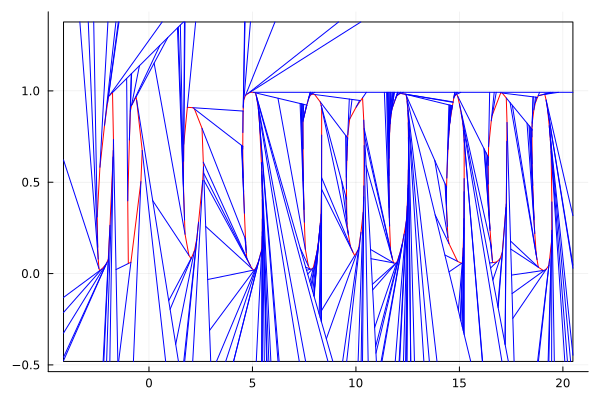

In [77]:
plot(xs[1][:],ys[1][:], linecolor = :red)
for i in 2:n_obstacle
    plot!(xs[i][:],ys[i][:], linecolor = :red)
end
plot!(xmap, ymap, linecolor = RGB(0,0,0), legend = false)
for i in 1:all_vertices-1
    plot!(x_free[i,:],y_free[i,:], linecolor = :blue)
end
plot!(x_free[all_vertices,:],y_free[all_vertices,:], linecolor = :blue, legend = false)


In [78]:
obstacle

10-element Vector{Any}:
 Any[Point(-2.3823248351344772, 0.016), Point(-2.4169220372807674, 0.0279999999999999), Point(-2.4517967740839763, 0.07899999999999989), Point(-2.475891606366119, 0.1439999999999999), Point(-2.502, 0.30999999999999994), Point(-2.369892441882836, 0.5820000000000001), Point(-2.1475437475572874, 0.811), Point(-2.0028922171357553, 0.934), Point(-1.9628573219945142, 0.9660000000000001), Point(-1.912272941271424, 0.9740000000000001), Point(-1.7614136484974279, 0.9910000000000001), Point(-1.7164865878042628, 0.7340000000000001), Point(-1.7250847159542333, 0.6740000000000002), Point(-1.7351127335917707, 0.6380000000000001), Point(-1.8841795586798276, 0.2640000000000001), Point(-1.967170527036794, 0.07700000000000011), Point(-2.0218294894463678, 0.0630000000000001), Point(-2.0501210842206996, 0.05600000000000009), Point(-2.0882435351985733, 0.04900000000000009), Point(-2.2751611663558853, 0.025000000000000126)]
 Any[Point(-0.9980872868318049, 0.05500000000000011), Point(